In [1]:
from gw_signal_tools.waveform_utils import (
    td_to_fd_waveform, fd_to_td_waveform,
    pad_to_get_target_df, restrict_f_range,
    get_strain
)

import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', '.*This code is currently UNREVIEWED, use with caution!.*')

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

# Waveform Conversion Verifications

First we need an example signal

In [3]:
# Define the dictionary
f_min = 20.*u.Hz

parameters_gw150914 = {
    'mass1' : 36*u.solMass,
    'mass2' : 29*u.solMass,
    'deltaT' : 1./2048.*u.s,
    'f22_start' : f_min,  # Lower cutoff frequency
    'f22_ref': 20.*u.Hz,# Frequency where spins are specified
    'phi_ref' : 0.*u.rad,
    'distance' : 1.*u.Mpc,
    'inclination' : 0.0*u.rad,
    'eccentricity' : 0.*u.dimensionless_unscaled,
    'longAscNodes' : 0.*u.rad,
    'meanPerAno' : 0.*u.rad,
    'condition' : 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'

# Call the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


# Generate time domain waveform
hp_t, hc_t = wfm.GenerateTDWaveform(parameters_gw150914, gen)


# Two waveforms will be generated in frequency domain, first with finer
# sampling and then with coarser one
hp_f_fine, hc_f_fine = wfm.GenerateFDWaveform(parameters_gw150914, gen)
hp_f_fine.override_unit(u.s)
hc_f_fine.override_unit(u.s)

hp_f_coarse, hc_f_coarse = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)
hp_f_coarse.override_unit(u.s)
hc_f_coarse.override_unit(u.s)

In [6]:
from gw_signal_tools.waveform_utils import get_signal_at_target_frequs

hp_f = get_signal_at_target_frequs(
    hp_f_fine,
    np.arange(-10.0, 100, step=hp_f_fine.df.value / 2) << u.Hz,
    fill_val=0.0 * u.s,
    unfilled_frequencies=[25.0 * u.Hz, 30.0 * u.Hz]
)

print(hp_f)

FrequencySeries([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j,
                 0.+0.j]
                unit: s,
                f0: -10.0 Hz,
                df: 0.03125 Hz,
                epoch: None,
                name: None,
                channel: None)


/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


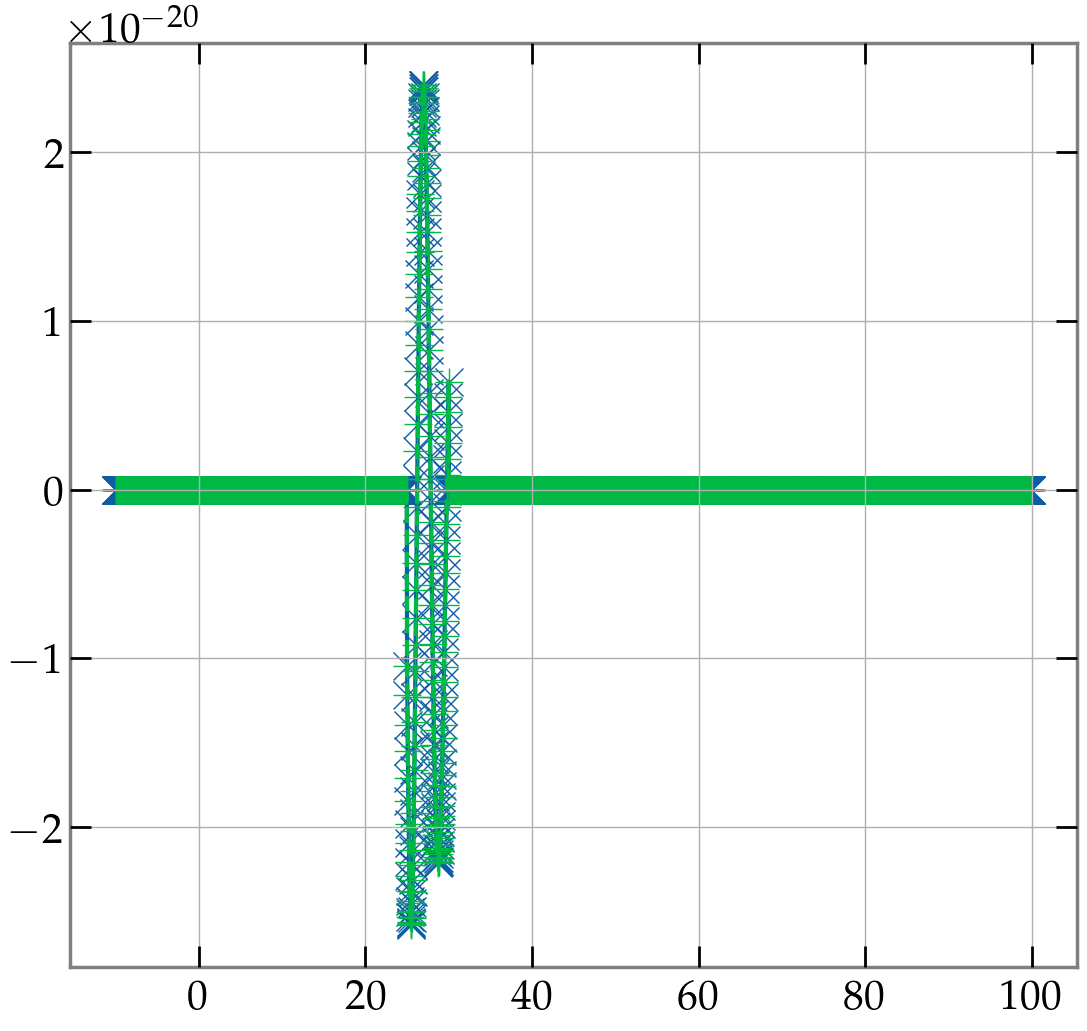

In [7]:
plt.plot(hp_f ,'x-')
plt.plot(hp_f ,'+--')
plt.show()

In [12]:
from gw_signal_tools.inner_product import inner_product, norm
from gw_signal_tools.PSDs import psd_no_noise

print(inner_product(hp_f_fine, hp_f_fine))
print(norm(hp_f_fine))
print(norm(hp_f_fine, psd=psd_no_noise))
print(norm(hp_f_fine, optimize_time_and_phase=True)[1])

6.502245541393563e-38
2.549950105667474e-19
2.549950105667474e-19
2.550957948423265e-19


## Sanity Checks

Transforming to one domain and back must yield the same waveform, up to essentially numerical precision

### Frequency Domain

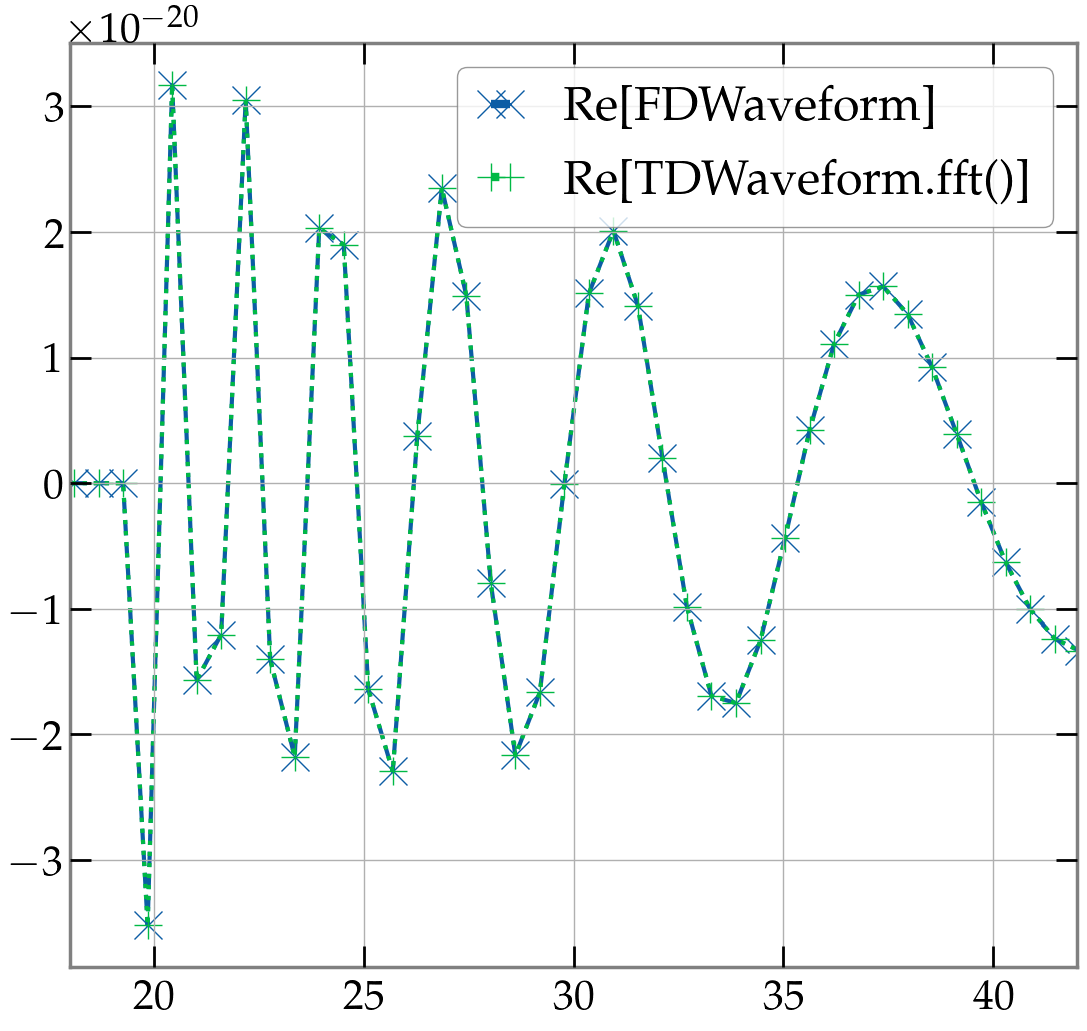

In [4]:
fig, ax = plt.subplots()

ax.plot(hp_f_coarse.real, 'x--', label='Re[FDWaveform]')

ax.plot(td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse)).real, '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([18, 42])
# ax.set_xlim([0, 256])

plt.show()

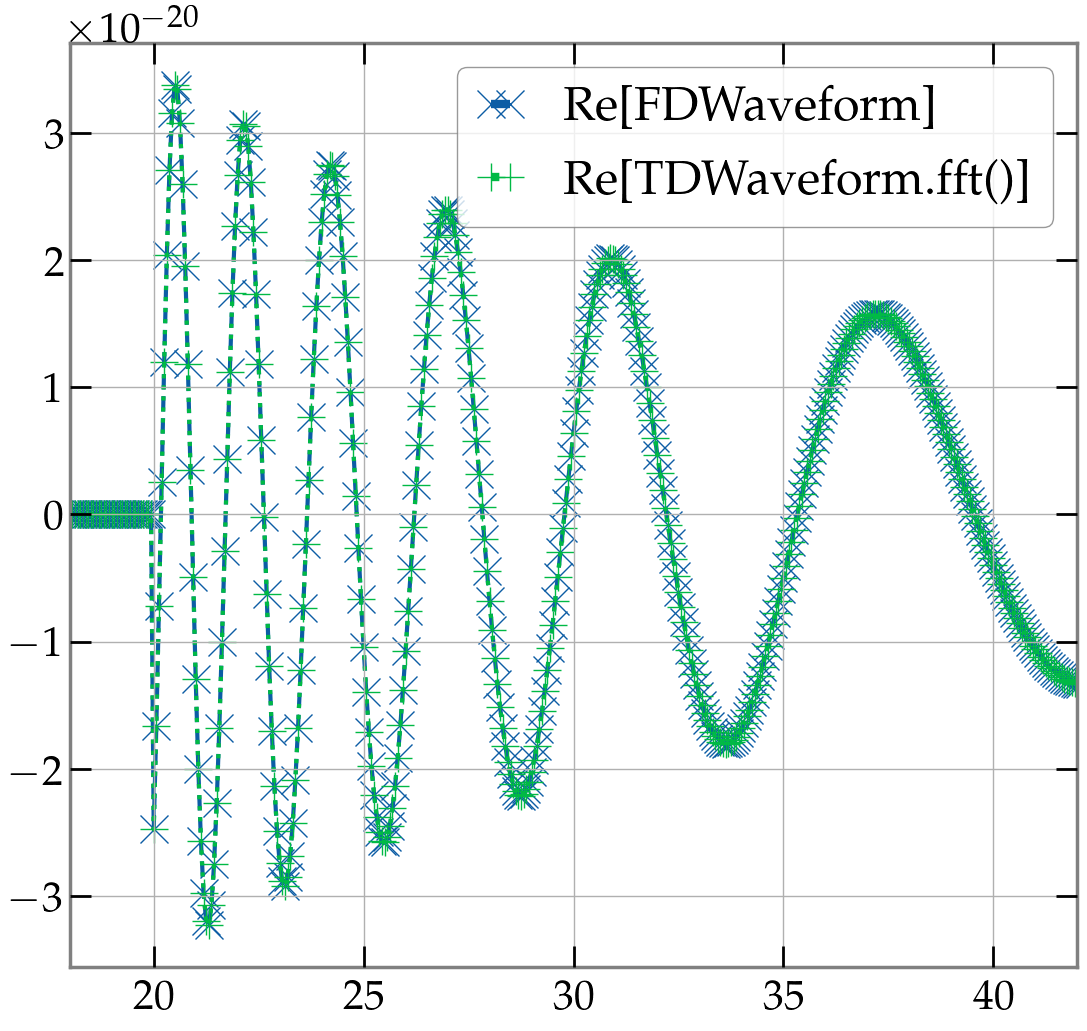

In [5]:
fig, ax = plt.subplots()

ax.plot(hp_f_fine.real, 'x--', label='Re[FDWaveform]')

ax.plot(td_to_fd_waveform(fd_to_td_waveform(hp_f_fine)).real, '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([18, 42])
# ax.set_xlim([0, 256])

plt.show()

In [6]:
f_min_comp, f_max_comp = 20.0 * u.Hz, 512.0 * u.Hz  # Restrict to interesting region, elsewhere only values close to zero and thus numerical errors might occur

print(np.all(np.isclose(np.real(hp_f_coarse.crop(start=f_min_comp, end=f_max_comp)), np.real(td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse)).crop(start=f_min_comp, end=f_max_comp)), atol=0.0, rtol=0.001)))
print(np.all(np.isclose(np.real(hp_f_fine.crop(start=f_min_comp, end=f_max_comp)), np.real(td_to_fd_waveform(fd_to_td_waveform(hp_f_fine)).crop(start=f_min_comp, end=f_max_comp)), atol=0.0, rtol=0.001)))

True
True


Equal up to at least 0.1%

For a visual proof of that we plot the absolute differences

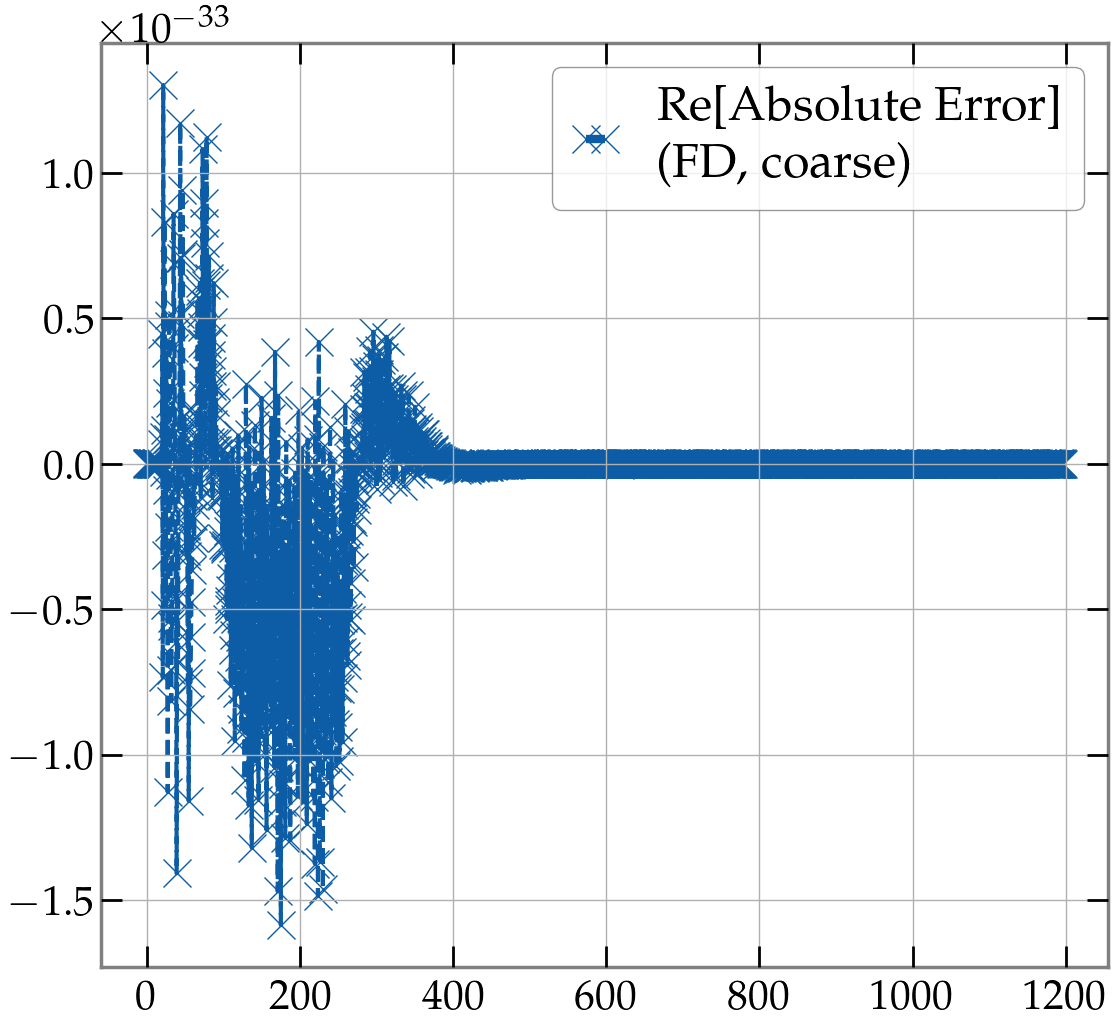

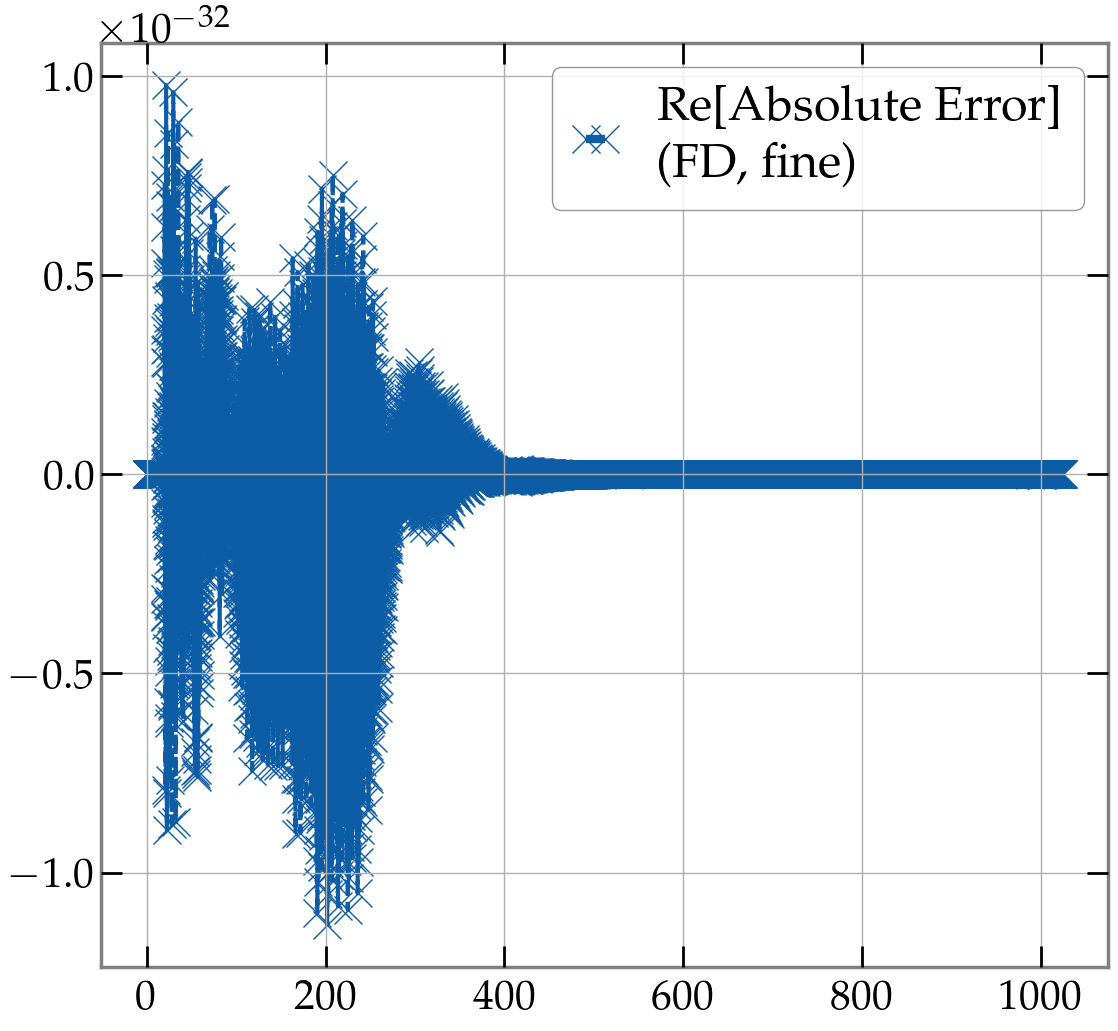

In [7]:
fig, ax = plt.subplots()

ax.plot((hp_f_coarse - td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse))).real, 'x--', label='Re[Absolute Error]\n(FD, coarse)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()



fig, ax = plt.subplots()

ax.plot((hp_f_fine - td_to_fd_waveform(fd_to_td_waveform(hp_f_fine))).real, 'x--', label='Re[Absolute Error]\n(FD, fine)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

These are essentially random errors, especially for first plot one can see no systematic in error signal

### Time Domain

In [8]:
hp_t_fft_ifft = fd_to_td_waveform(td_to_fd_waveform(hp_t))

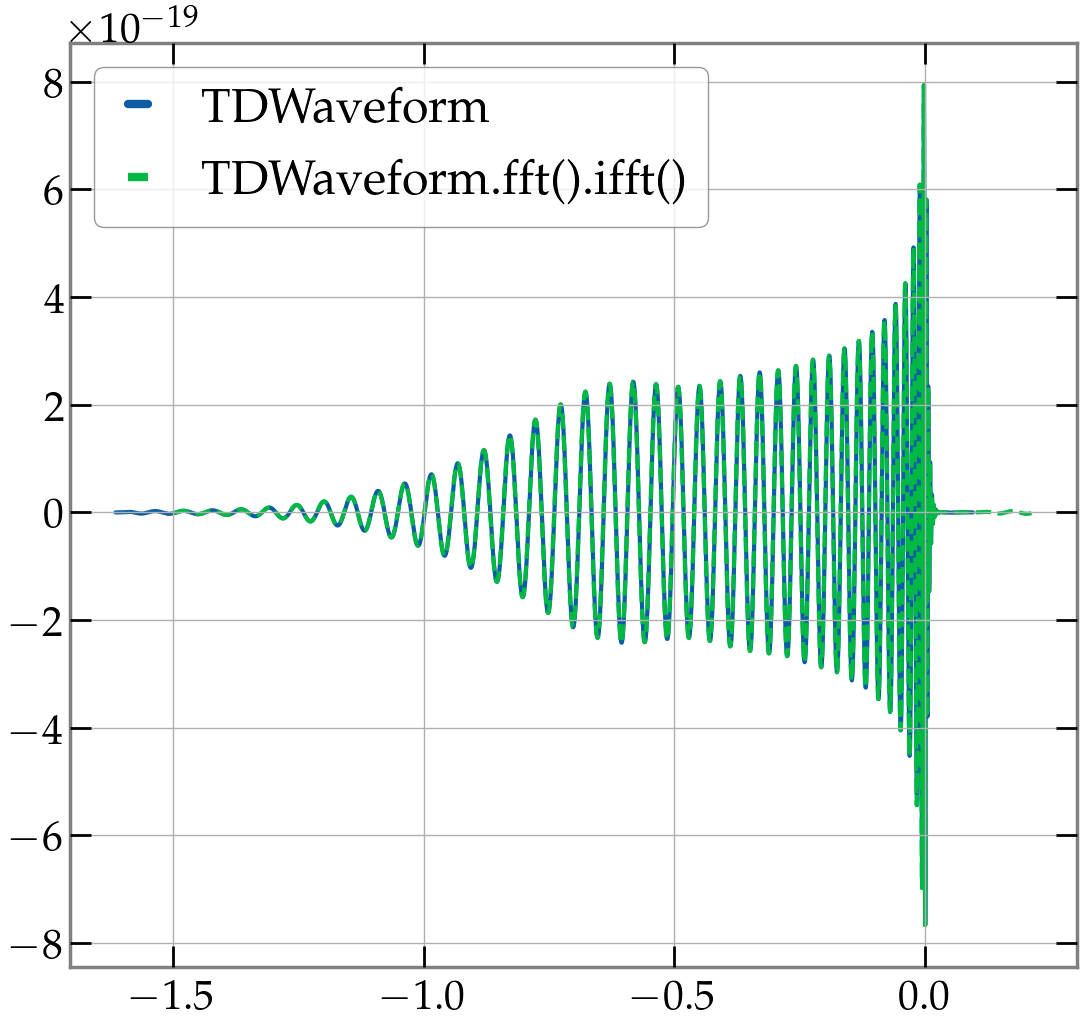

In [9]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_fft_ifft, '--', label='TDWaveform.fft().ifft()')

ax.legend()

# ax.set_xlim([-0.75, 0.1])
# ax.set_xlim([-0.1, 0.025])

plt.show()

Good agreement, apart from different end and start points everything is roughly equal. When zooming in, a slight phase shift can be observed, which makes sense given the rather raw sampling in frequency domain that this coarsely sampled signal represents (see signal in frequency domain).

This must not change for smaller df.

In [10]:
hp_t_fft_ifft_fine = fd_to_td_waveform(td_to_fd_waveform(pad_to_get_target_df(hp_t, df=0.0625 * u.Hz)))

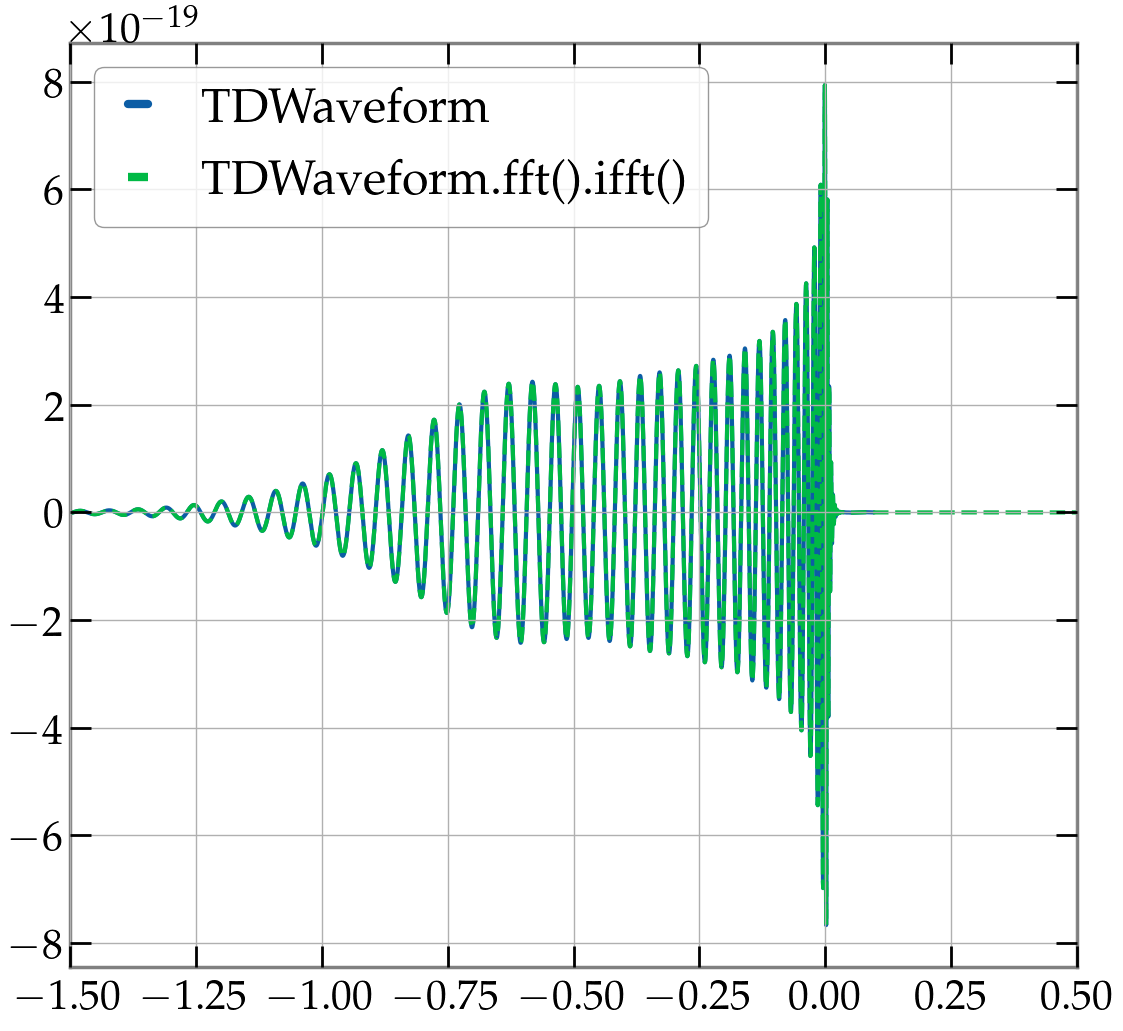

In [11]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_fft_ifft_fine, '--', label='TDWaveform.fft().ifft()')

ax.legend()

ax.set_xlim([-1.5, 0.5])
# ax.set_xlim([-0.1, 0.025])

plt.show()

In [12]:
t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft_fine.t0), min(hp_t.times[-1], hp_t_fft_ifft_fine.times[-1])  # hp_t_fft_ifft_fine is padded to be much longer

print(np.all(np.isclose(hp_t.crop(start=t_min_comp, end=t_max_comp)[1:], hp_t_fft_ifft_fine.crop(start=t_min_comp, end=t_max_comp)[1:], atol=0.0, rtol=0.001)))
# Note: for some reason, first sample is not equal. Thus excluded here

True


Equal up to at least 0.1% for fine sampling. For coarse sampling, the following plot of absolute deviations shows a maximum amplitude error of roughly 10% prior to the signal. Of course, this is a substantial deviation, which shows the need for sufficiently fine sampling.

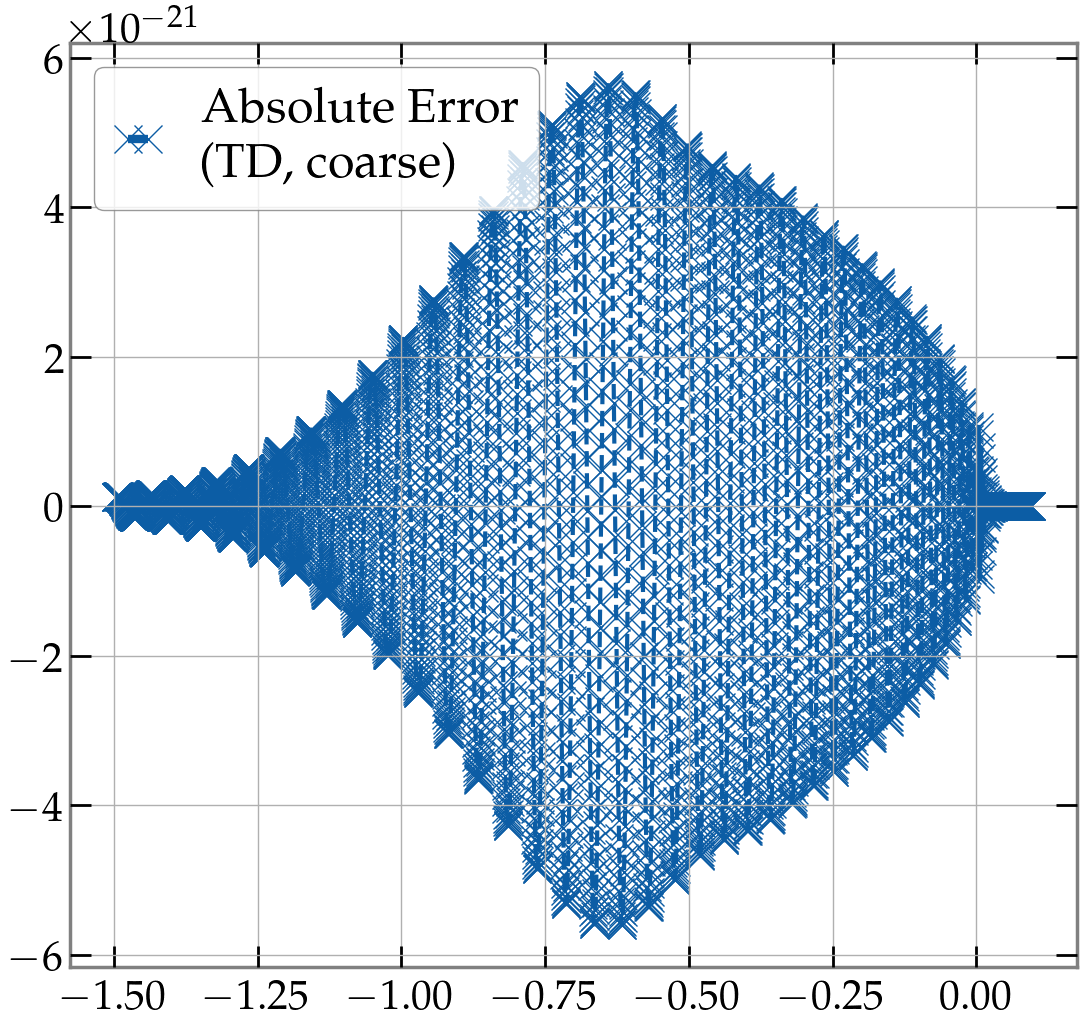

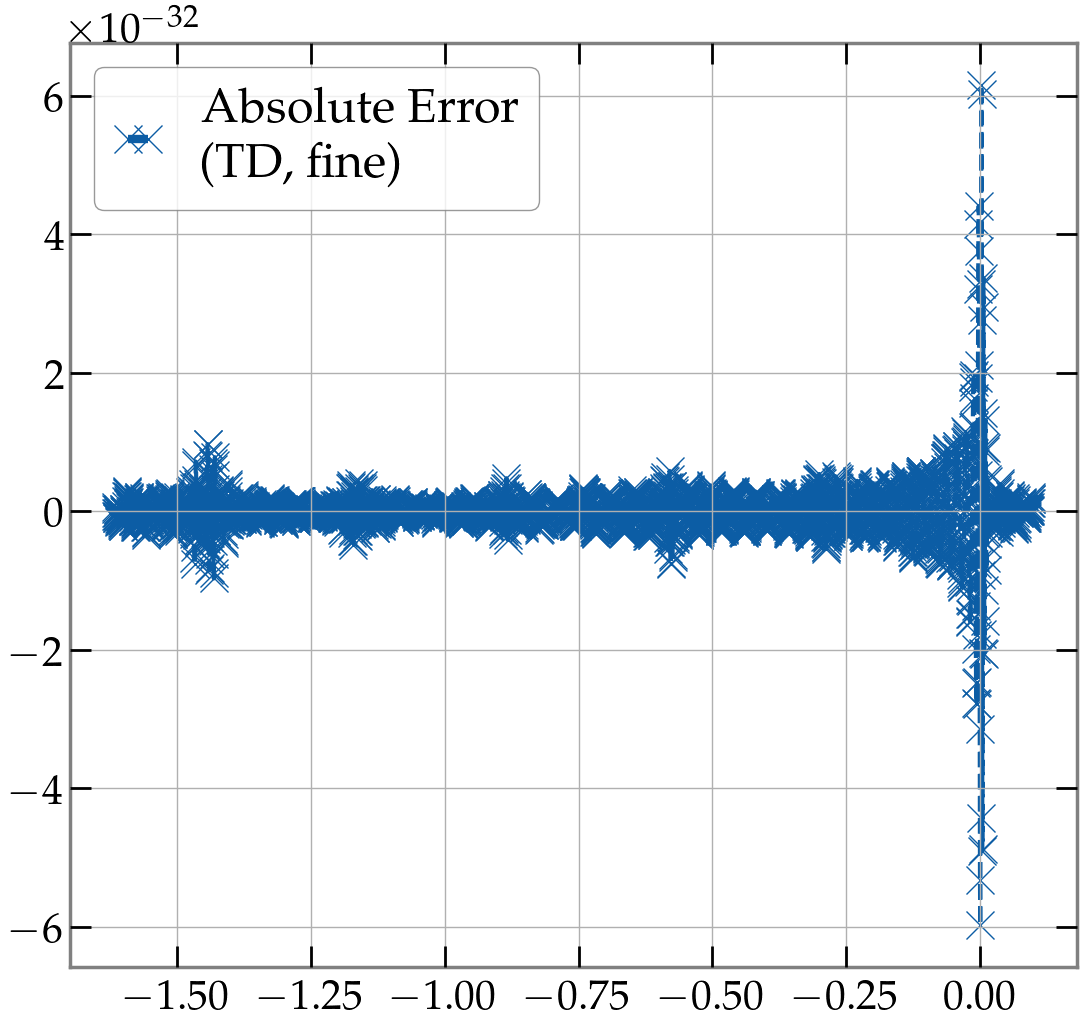

In [13]:
t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft.t0), min(hp_t.times[-1], hp_t_fft_ifft.times[-1])


fig, ax = plt.subplots()

ax.plot(hp_t.crop(start=t_min_comp, end=t_max_comp)[2:] - hp_t_fft_ifft.crop(start=t_min_comp, end=t_max_comp), 'x--', label='Absolute Error\n(TD, coarse)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()



t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft_fine.t0), min(hp_t.times[-1], hp_t_fft_ifft_fine.times[-1])

fig, ax = plt.subplots()

ax.plot(hp_t.crop(start=t_min_comp, end=t_max_comp) - hp_t_fft_ifft_fine.crop(start=t_min_comp, end=t_max_comp), 'x--', label='Absolute Error\n(TD, fine)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

## Time Domain to Frequency Domain

- TODO for each: make zoom only in inset

Now we compare how well the FDWaveform generated by lal and our transformed TDWaveform agree

In [14]:
hp_t_f_coarse = td_to_fd_waveform(hp_t)

# For a finer resolution, we have to pad signal
hp_t_padded = pad_to_get_target_df(hp_t, df=hp_f_fine.df)
hp_t_f_fine = td_to_fd_waveform(hp_t_padded)

In [15]:
print(hp_f_coarse.df, hp_t_f_coarse.df)

print(hp_f_fine.df, hp_t_f_fine.df)

0.5839749073282008 Hz 0.5839749073282008 1 / s
0.0625 Hz 0.0625 1 / s


This demonstrates that `pad_to_get_target_df` does its job

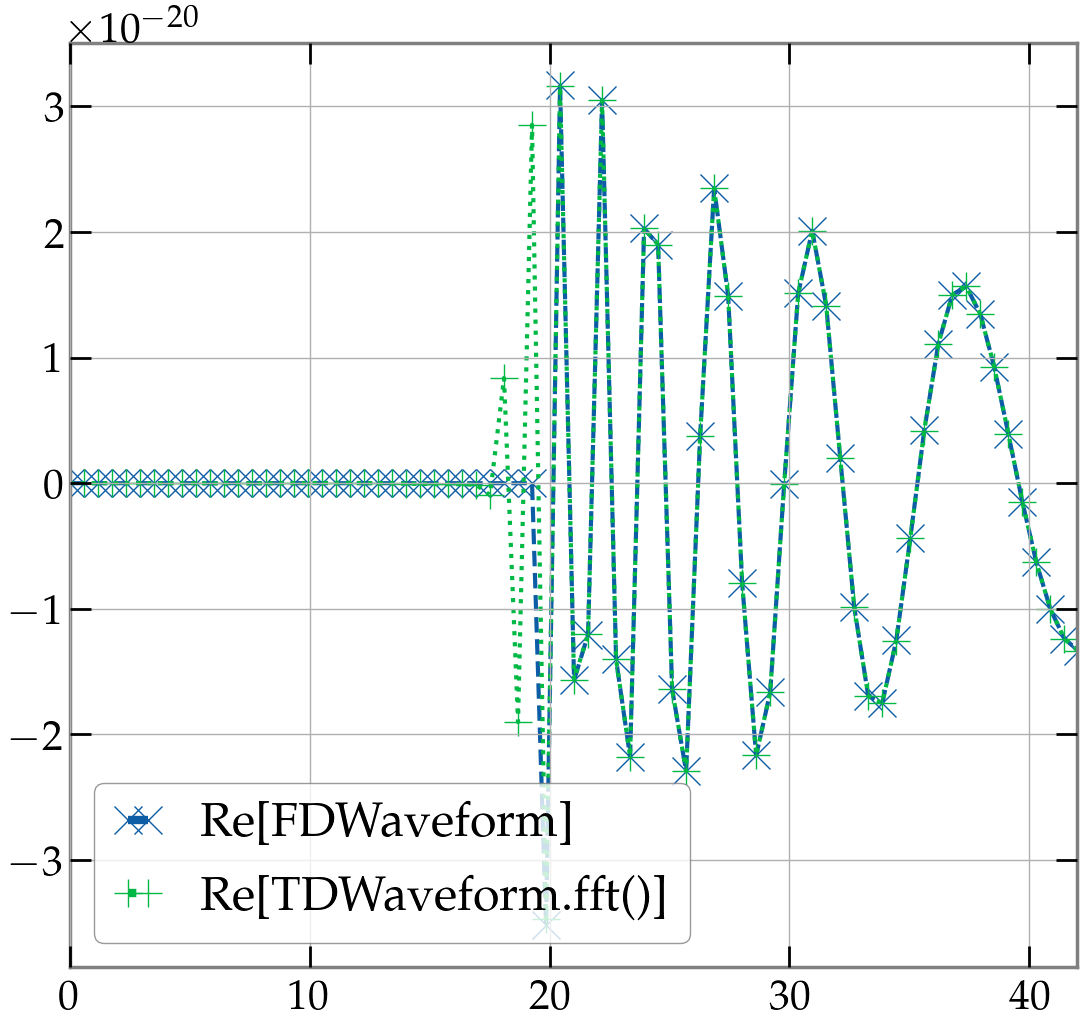

In [16]:
fig, ax = plt.subplots()

ax.plot(hp_f_coarse.real, 'x--', label='Re[FDWaveform]')

ax.plot(hp_t_f_coarse.real, '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

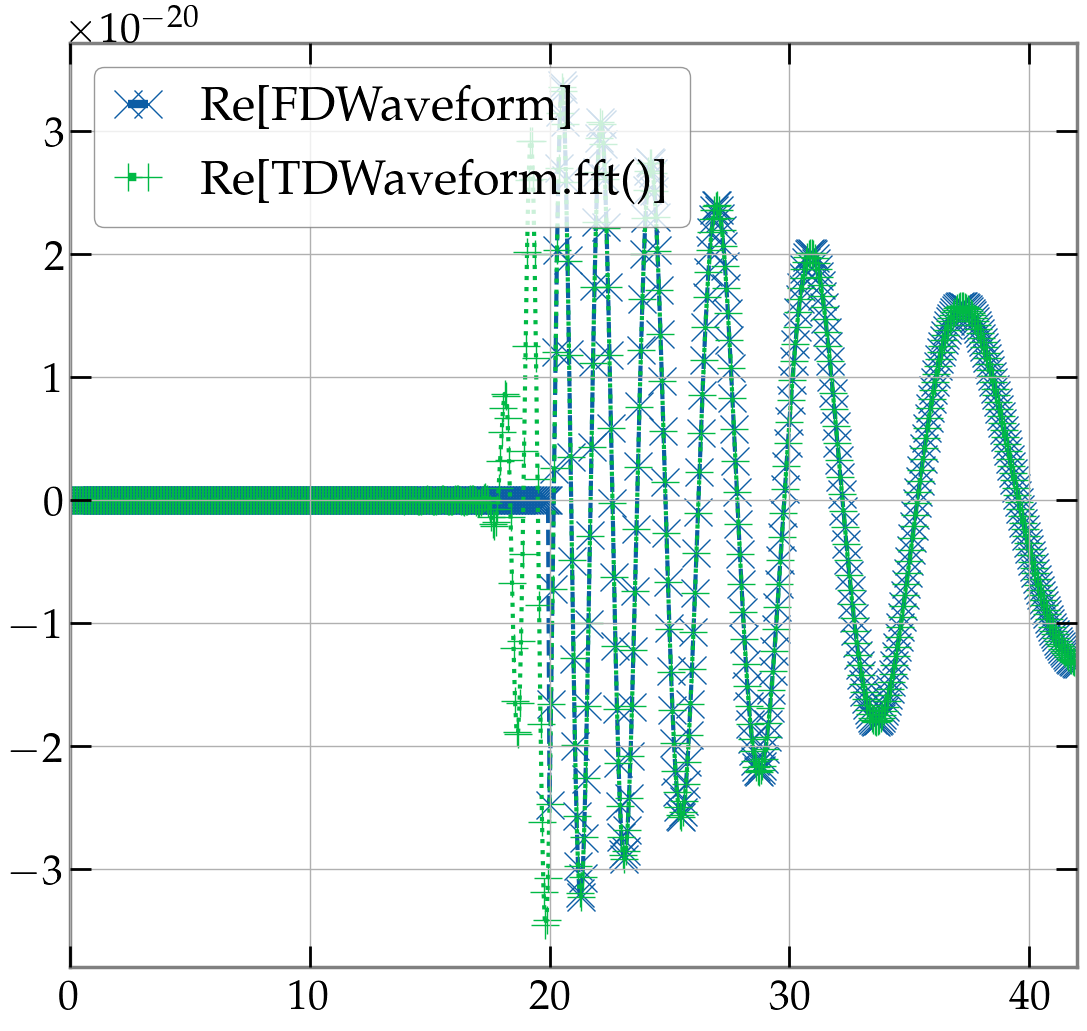

In [17]:
fig, ax = plt.subplots()

ax.plot(hp_f_fine.real, 'x--', label='Re[FDWaveform]')

ax.plot(hp_t_f_fine.real, '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

In [18]:
f_min_comp, f_max_comp = 25.0 * u.Hz, 512.0 * u.Hz  # Restrict to interesting region, elsewhere only values close to zero and thus numerical errors might occur

print(np.all(np.isclose(hp_f_coarse.crop(start=f_min_comp, end=f_max_comp), hp_t_f_coarse.crop(start=f_min_comp, end=f_max_comp), atol=0.0, rtol=0.01)))
print(np.all(np.isclose(hp_f_fine.crop(start=f_min_comp, end=f_max_comp), hp_t_f_fine.crop(start=f_min_comp, end=f_max_comp), atol=0.0, rtol=0.01)))

True
True


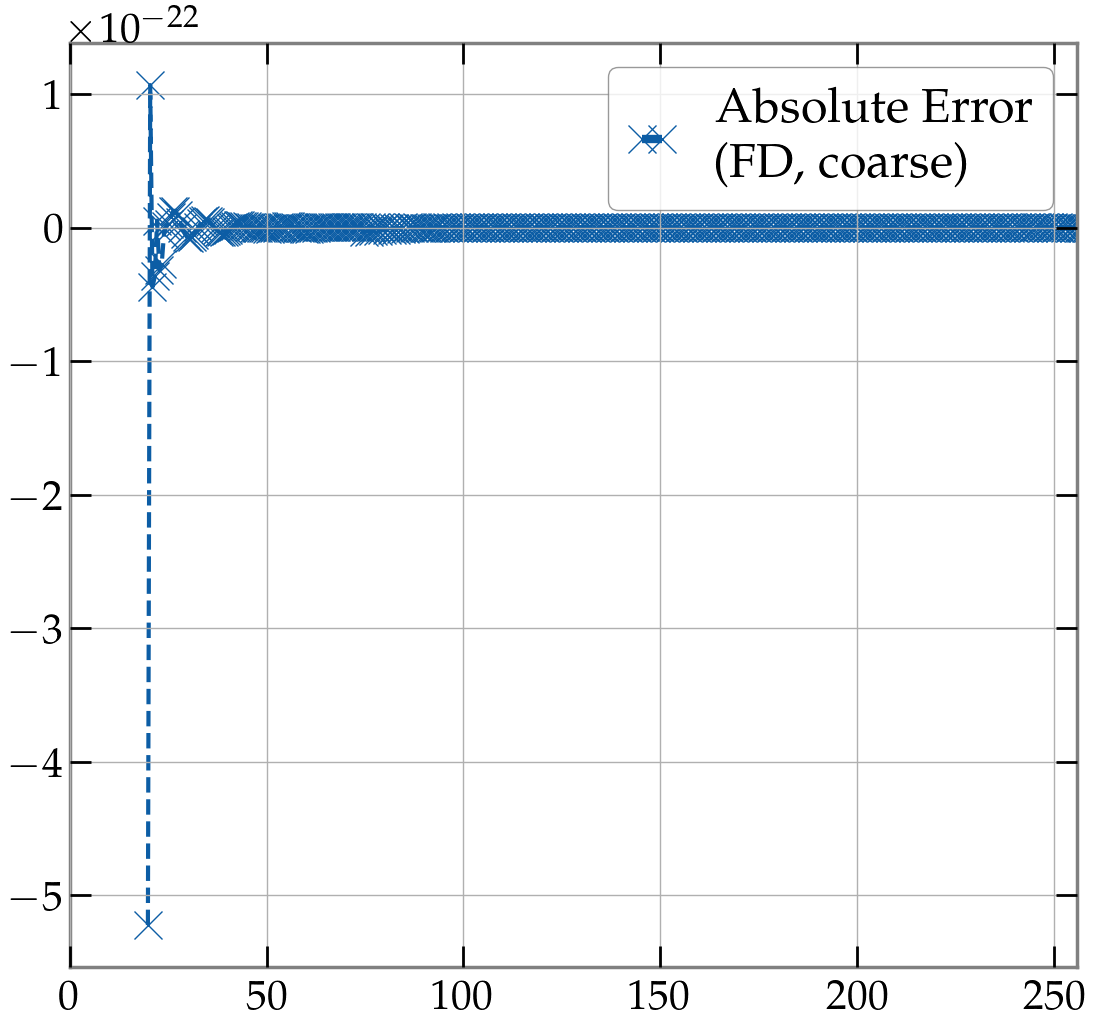

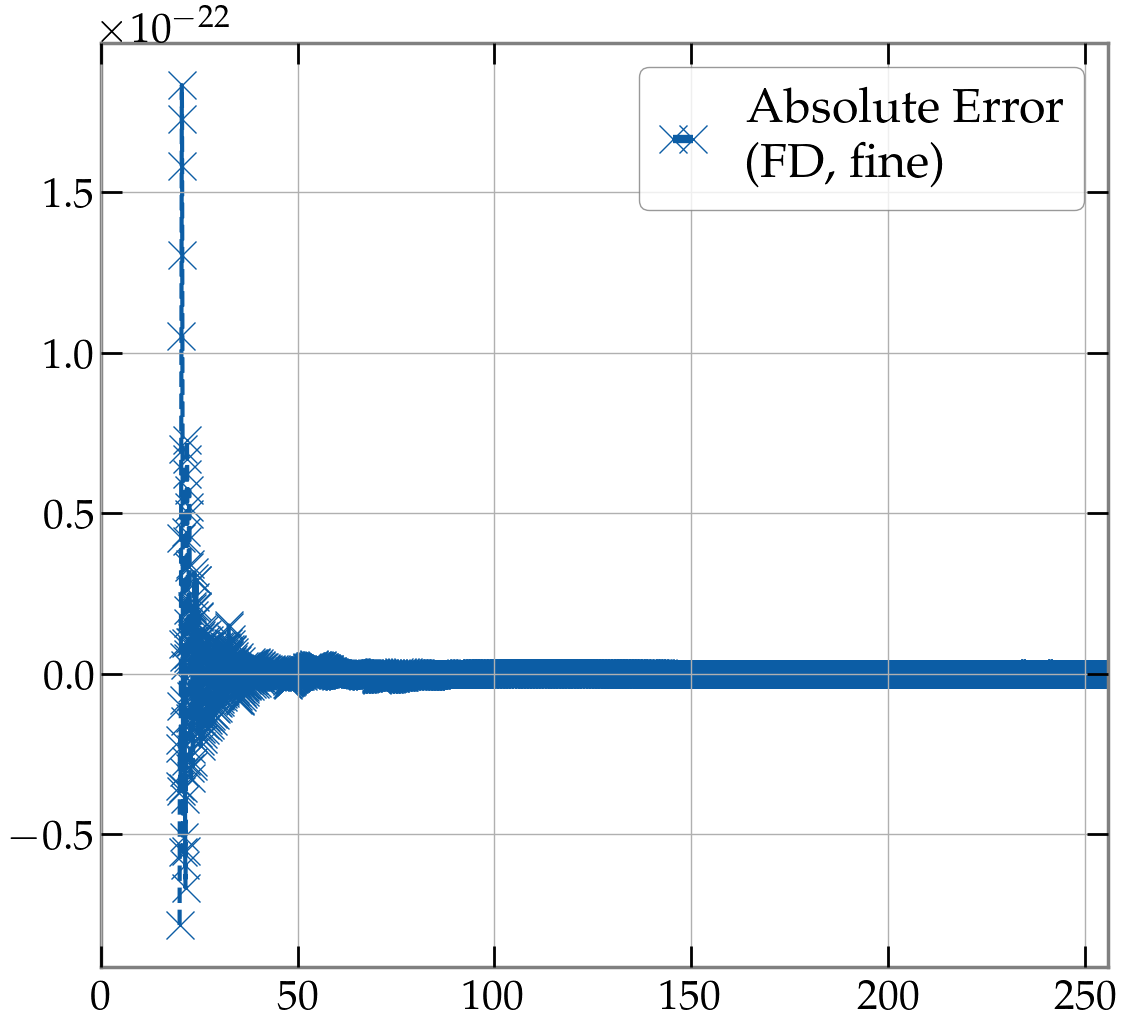

In [19]:
f_min_comp, f_max_comp = 20.0 * u.Hz, 512.0 * u.Hz  # Restrict to interesting region, elsewhere only values close to zero and thus numerical errors might occur


fig, ax = plt.subplots()

ax.plot((hp_f_coarse.crop(start=f_min_comp, end=f_max_comp) - hp_t_f_coarse.crop(start=f_min_comp, end=f_max_comp)).real, 'x--', label='Absolute Error\n(FD, coarse)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()



t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft_fine.t0), min(hp_t.times[-1], hp_t_fft_ifft_fine.times[-1])

fig, ax = plt.subplots()

ax.plot((hp_f_fine.crop(start=f_min_comp, end=f_max_comp) - hp_t_f_fine.crop(start=f_min_comp, end=f_max_comp)).real, 'x--', label='Absolute Error\n(FD, fine)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()

Very good agreement, except for beginning. Here, the FDWaveform perhaps has some tapering applied or the corresponding TDWaveform we use for own FFT has - in any case, there is a residual influence of this, causing slightly higher disagreement.

## Frequency Domain to Time Domain

Now we compare how well the TDWaveform generated by lal and our transformed FDWaveform agree

In [20]:
hp_f_t_coarse = fd_to_td_waveform(hp_f_coarse)
hp_f_t_fine = fd_to_td_waveform(hp_f_fine)

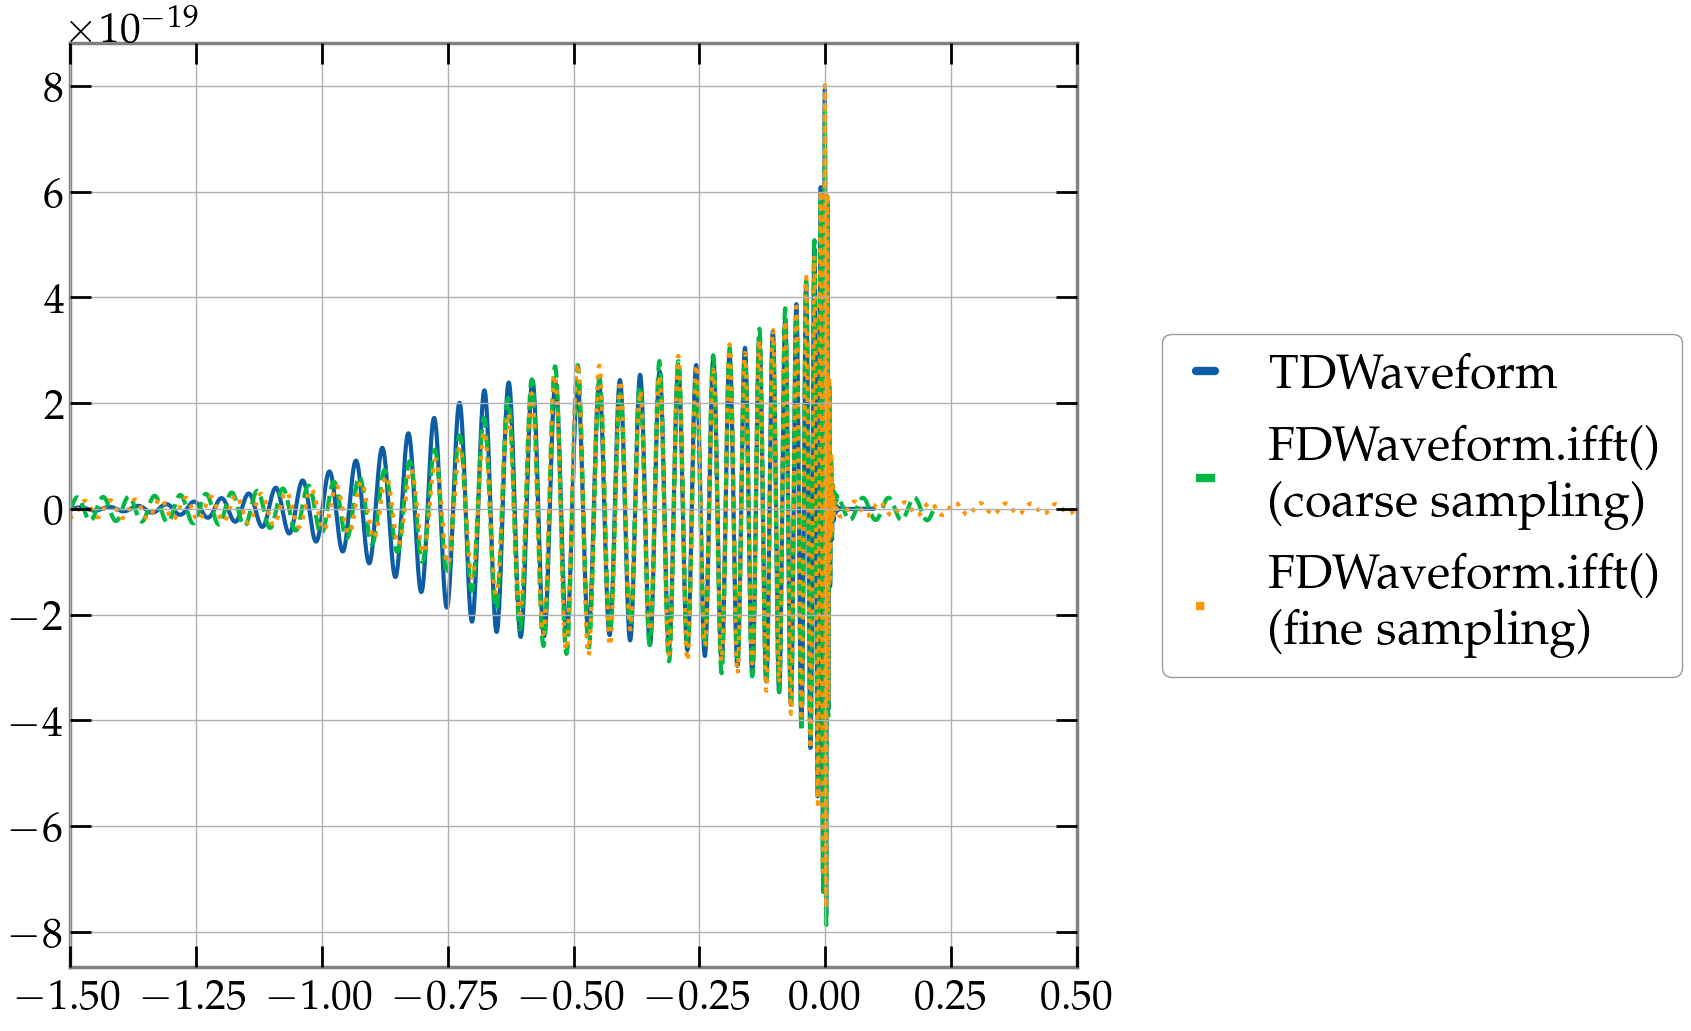

In [21]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_f_t_fine, ':', label='FDWaveform.ifft()\n(fine sampling)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-1.5, 0.5])

plt.show()

Close to merger, agreement has to be best

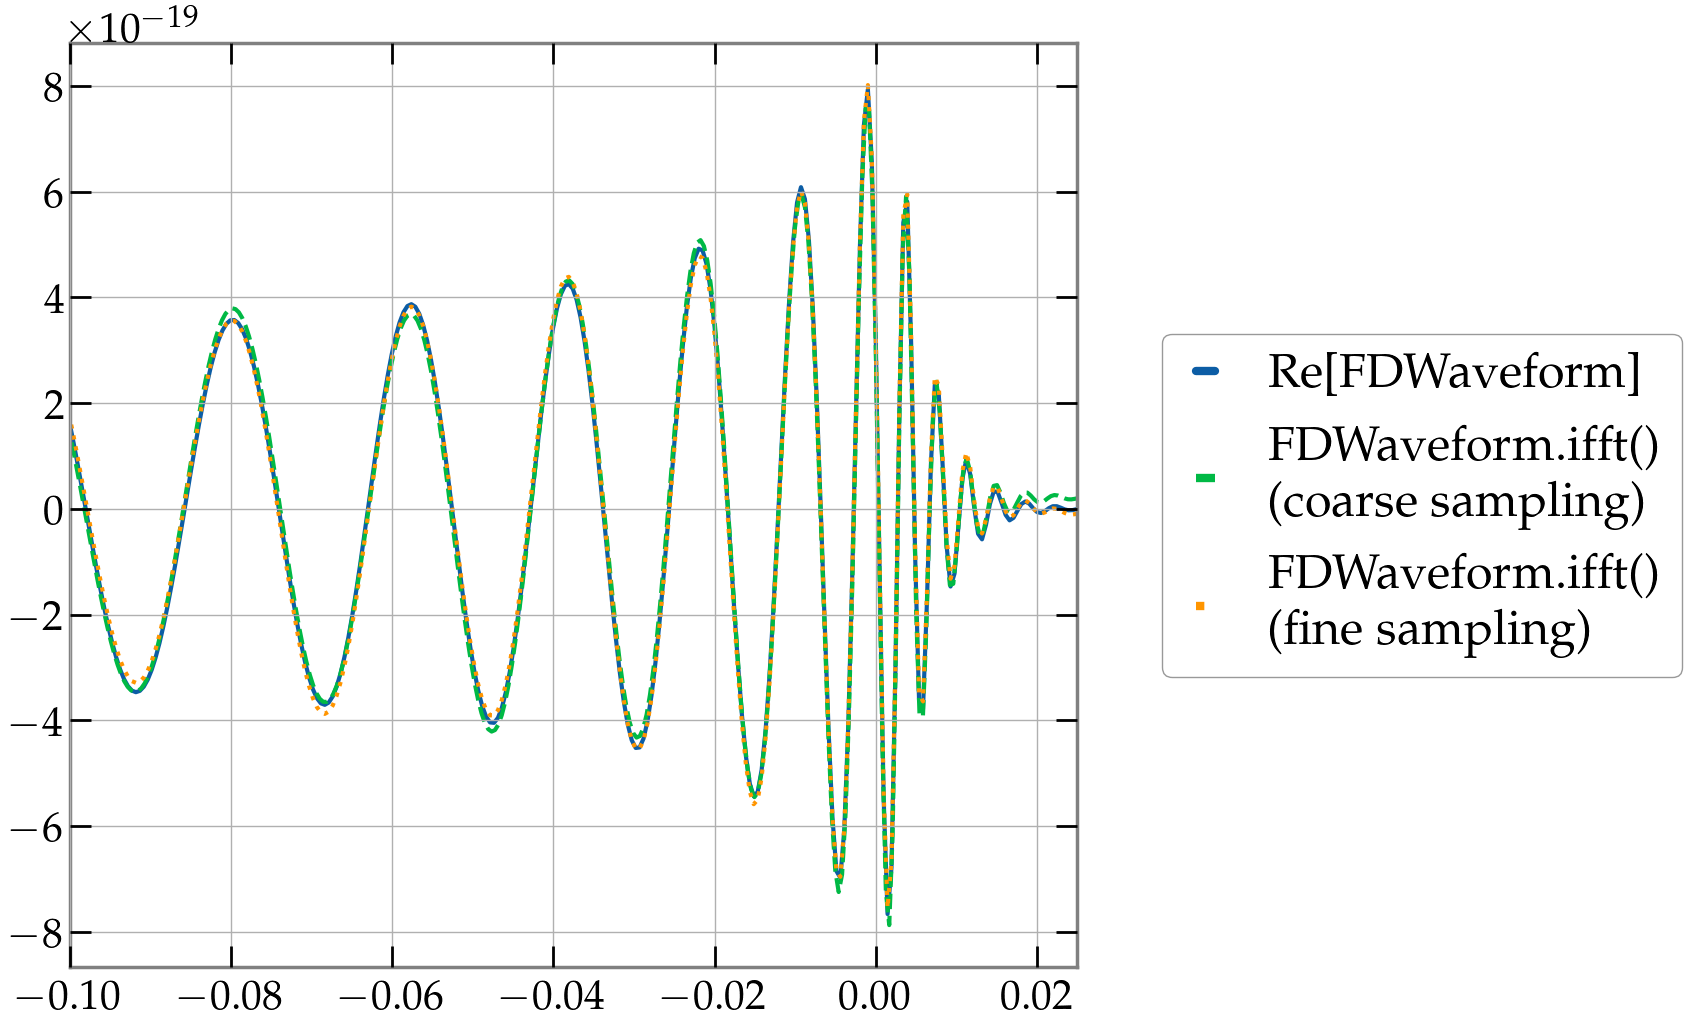

In [22]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='Re[FDWaveform]')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_f_t_fine, ':', label='FDWaveform.ifft()\n(fine sampling)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

# ax.set_xlim([-0.5, 0.05])
ax.set_xlim([-0.1, 0.025])

plt.show()

Differences between coarse and fine sampling remain, which makes sense. For fine sampling, the results are reasonably equal.

Most of the differences from the plot before are perhaps caused by tapering that we do not apply, but is applied for lal waveform

## Consistency of `get_strain` with manual generation and of rfft with fft

In [23]:
h_t = hp_t + 1.j * hc_t

h_f_fine = hp_f_fine + 1.j * hc_f_fine
h_f_coarse = hp_f_coarse + 1.j * hc_f_coarse

### `get_strain`

In [24]:
h_t_2 = get_strain(parameters_gw150914, 'time', wf_generator=gen, mode='mixed')
h_t_f_coarse_2 = td_to_fd_waveform(h_t)
h_t_f_fine_2 = td_to_fd_waveform(pad_to_get_target_df(h_t, df=0.0625))

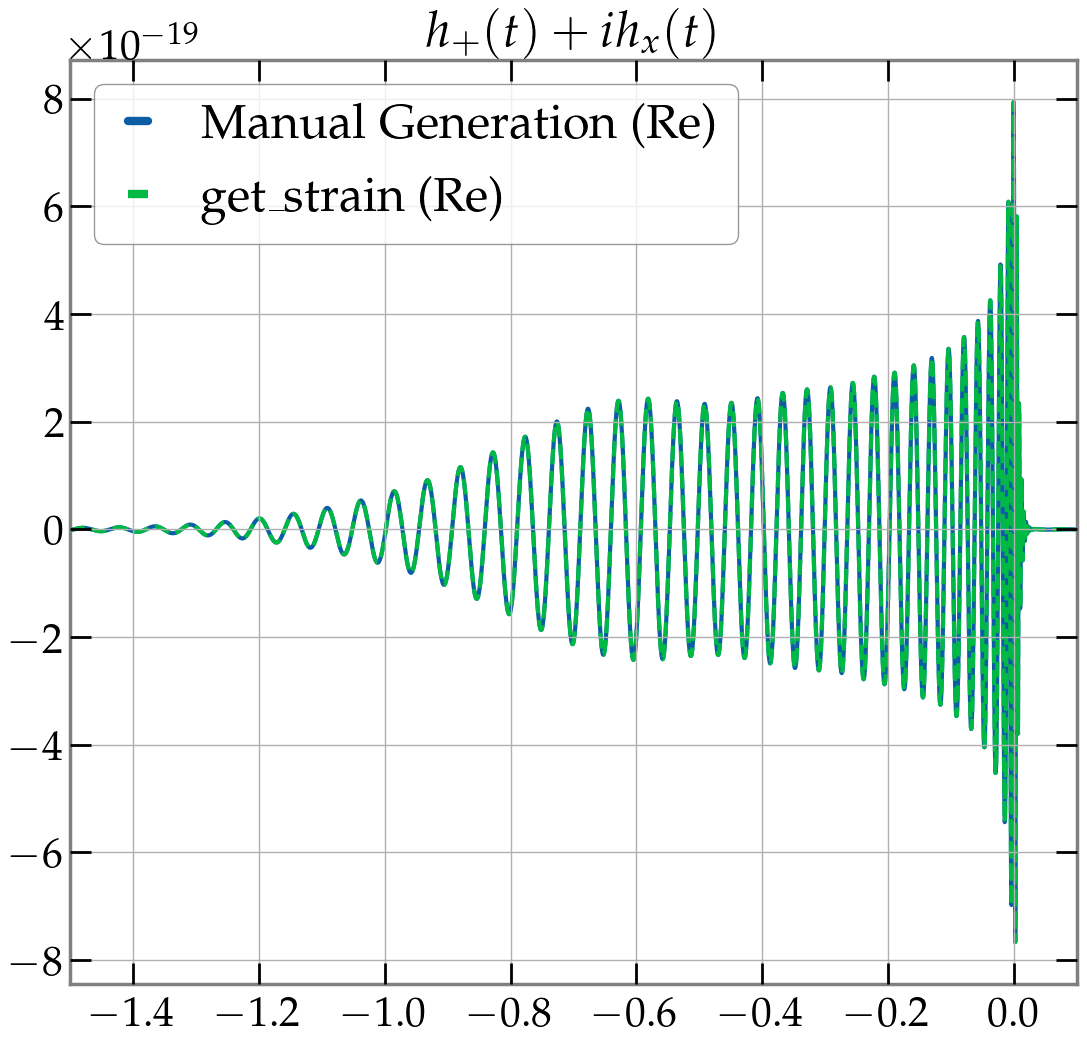

In [25]:
fig, ax = plt.subplots()

ax.plot(h_t.real, label='Manual Generation (Re)')
ax.plot(h_t_2.real, '--', label='get_strain (Re)')

# ax.plot(h_t.imag, label='Manual Generation (Im)')
# ax.plot(h_t_2.imag, '--', label='get_strain (Im)')

# ax.plot(h_t.abs(), label='Manual Generation (abs)')
# ax.plot(h_t_2.abs(), '--', label='get_strain (abs)')

ax.legend()
ax.set_title('$h_+(t) + i h_x(t)$')

ax.set_xlim([-1.5, 0.1])
# ax.set_xlim([-0.25, 0.01])

plt.show()

In [26]:
hp_f_fine_2 = get_strain(parameters_gw150914, 'frequency', wf_generator=gen, mode='plus')
h_f_fine_2 = get_strain(parameters_gw150914, 'frequency', wf_generator=gen, mode='mixed')

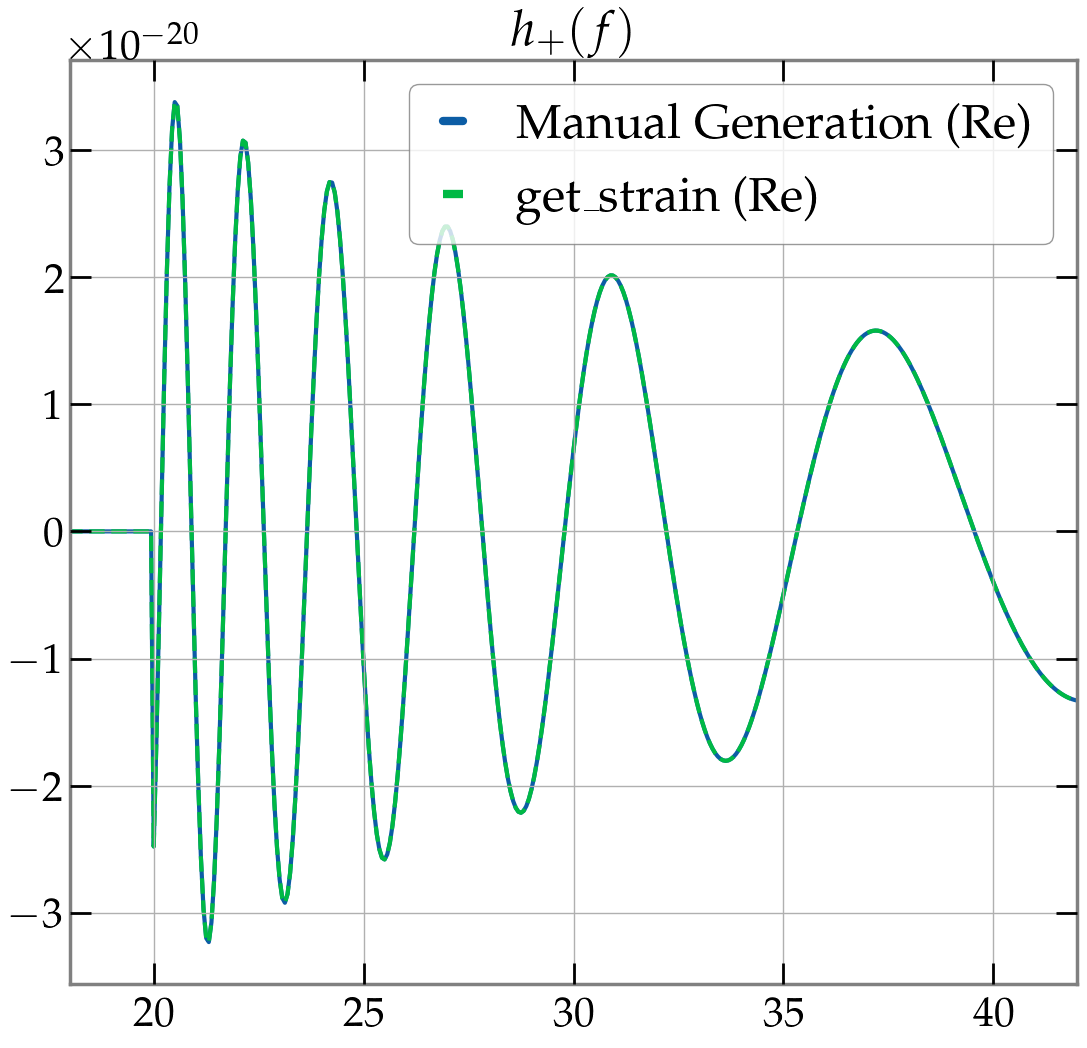

In [27]:
fig, ax = plt.subplots()

ax.plot(hp_f_fine.real, label='Manual Generation (Re)')
ax.plot(hp_f_fine_2.real, '--', label='get_strain (Re)')

# ax.plot(hp_f_fine.imag, label='Manual Generation (Im)')
# ax.plot(hp_f_fine_2.imag, '--', label='get_strain (Im)')

# ax.plot(hp_f_fine.abs(), label='Manual Generation (abs)')
# ax.plot(hp_f_fine_2.abs(), '--', label='get_strain (abs)')

ax.legend()
ax.set_title('$h_+(f)$')

ax.set_xlim([18, 42])
# ax.set_xlim([0, 60])

plt.show()

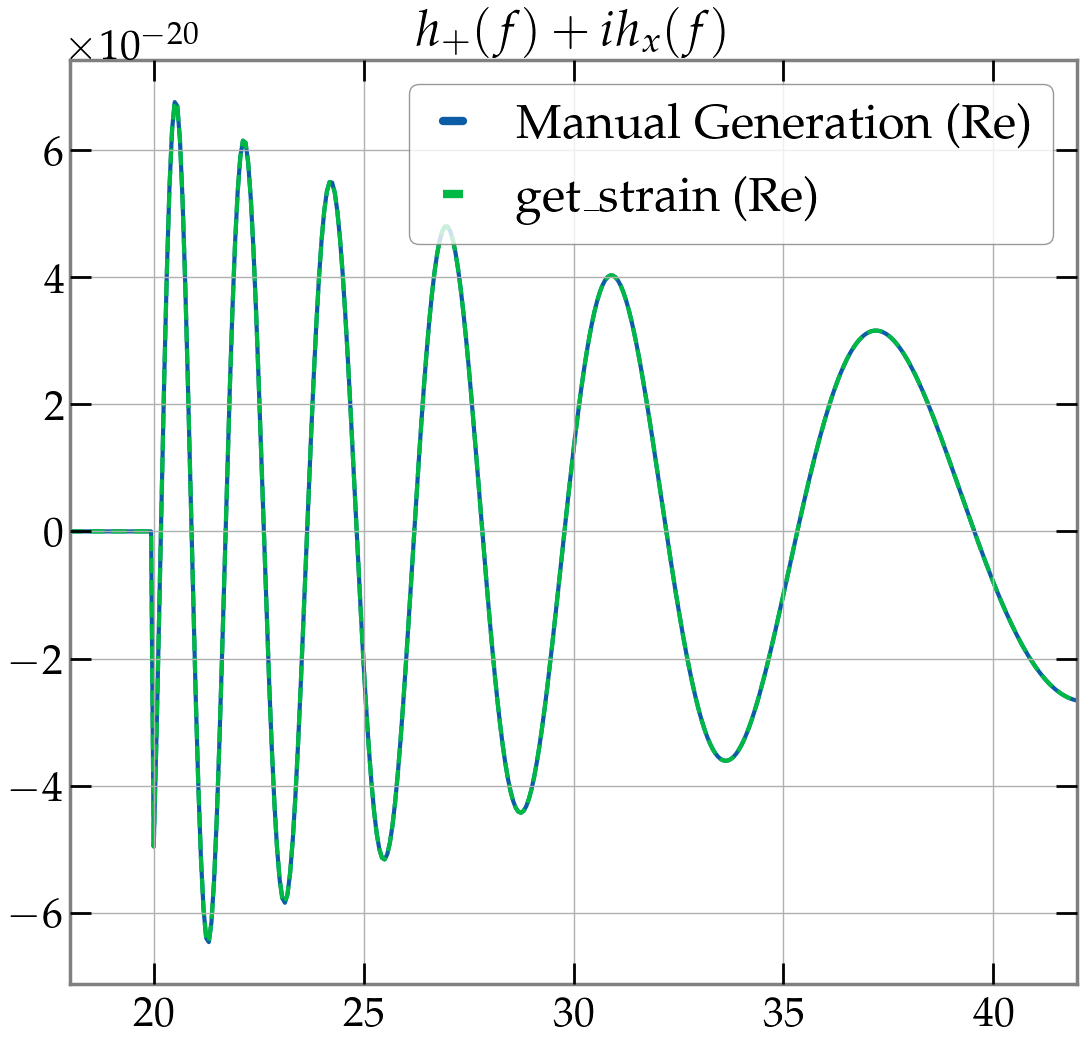

In [28]:
fig, ax = plt.subplots()

ax.plot(h_f_fine.real, label='Manual Generation (Re)')
ax.plot(h_f_fine_2.real, '--', label='get_strain (Re)')

# ax.plot(h_f_fine.imag, label='Manual Generation (Im)')
# ax.plot(h_f_fine_2.imag, '--', label='get_strain (Im)')

# ax.plot(h_f_fine.abs(), label='Manual Generation (abs)')
# ax.plot(h_f_fine_2.abs(), '--', label='get_strain (abs)')

ax.legend()
ax.set_title('$h_+(f) + i h_x(f)$')

ax.set_xlim([18, 42])
# ax.set_xlim([0, 60])

plt.show()

### rfft/fft

In [29]:
h_t_f_coarse = td_to_fd_waveform(h_t)
h_t_f_fine = td_to_fd_waveform(pad_to_get_target_df(h_t, df=0.0625))

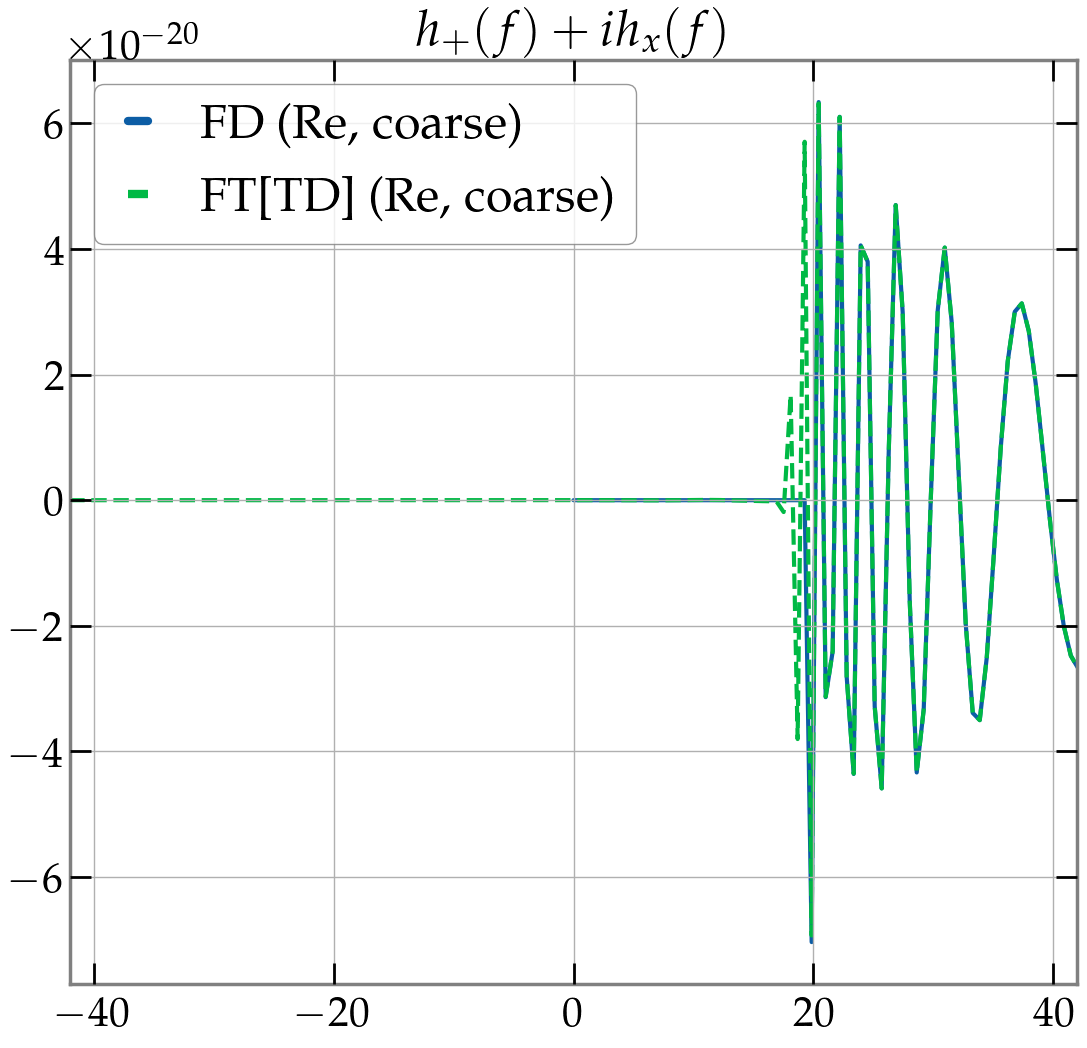

In [30]:
fig, ax = plt.subplots()

ax.plot(h_f_coarse.real, label='FD (Re, coarse)')
ax.plot(h_t_f_coarse.real, '--', label='FT[TD] (Re, coarse)')

# ax.plot(h_f_coarse.imag, label='FD (Im, coarse)')
# ax.plot(h_t_f_coarse.imag, '--', label='FT[TD] (Im, coarse)')

# ax.plot(h_f_coarse.abs(), label='FD (abs, coarse)')
# ax.plot(h_t_f_coarse.abs(), '--', label='FT[TD] (abs, coarse)')

ax.legend()
ax.set_title('$h_+(f) + i h_x(f)$')

# ax.set_xlim([0, 42])
ax.set_xlim([-42, 42])

plt.show()

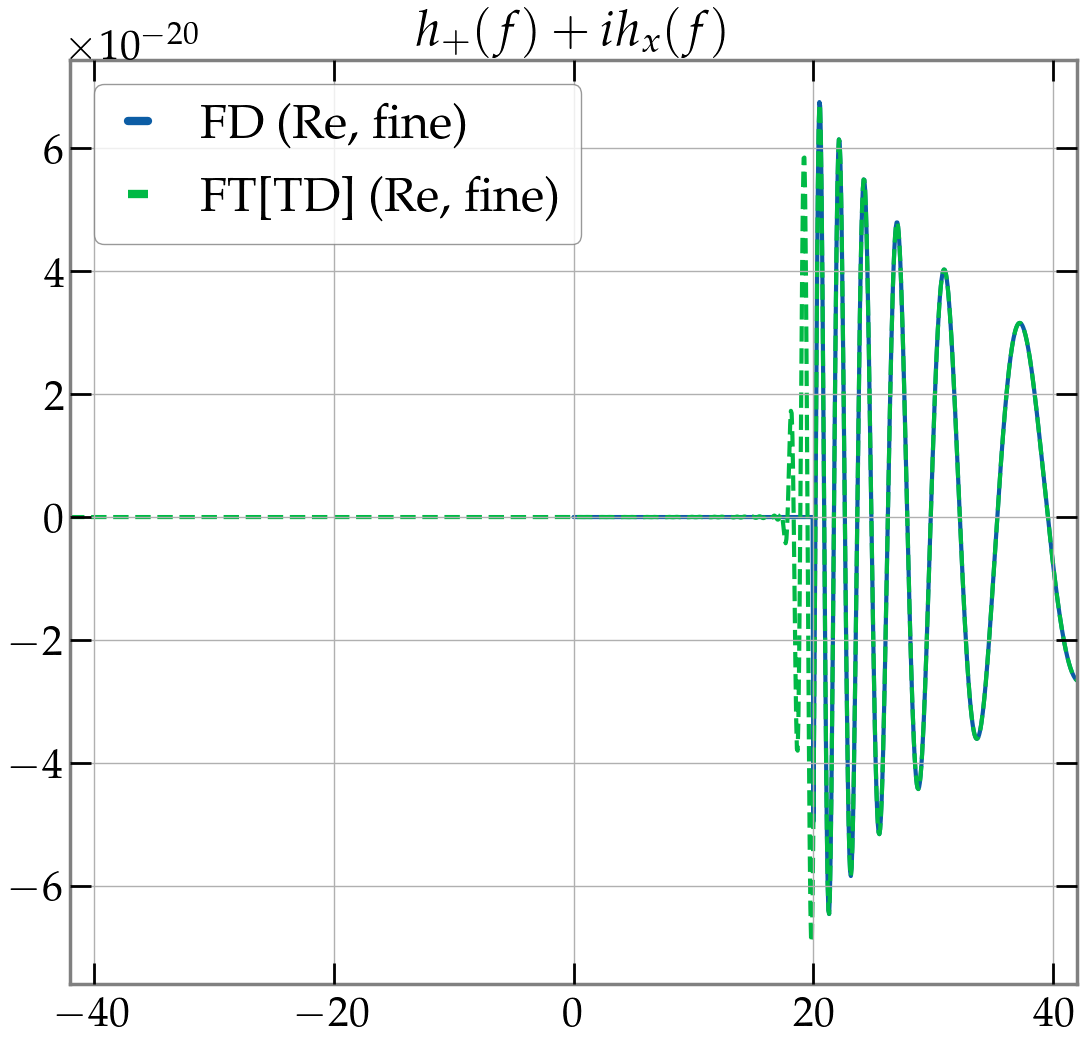

In [31]:
fig, ax = plt.subplots()

ax.plot(h_f_fine.real, label='FD (Re, fine)')
ax.plot(h_t_f_fine.real, '--', label='FT[TD] (Re, fine)')

# ax.plot(h_f_fine.imag, label='FD (Im, fine)')
# ax.plot(h_t_f_fine.imag, '--', label='FT[TD] (Im, fine)')

# ax.plot(h_f_fine.abs(), label='FD (abs, fine)')
# ax.plot(h_t_f_fine.abs(), '--', label='FT[TD] (abs, fine)')

ax.legend()
ax.set_title('$h_+(f) + i h_x(f)$')

# ax.set_xlim([0, 42])
ax.set_xlim([-42, 42])

plt.show()

Now we show that using the rfft is justified. We do that by adding an vanishing imaginary part to $h_+$ (which still converts the type to complex).

In [32]:
hp_t_complex = hp_t + 1.j * 0.0

hp_t_complex_f_coarse = td_to_fd_waveform(hp_t_complex)
hp_t_complex_f_fine = td_to_fd_waveform(pad_to_get_target_df(hp_t_complex, df=0.0625))

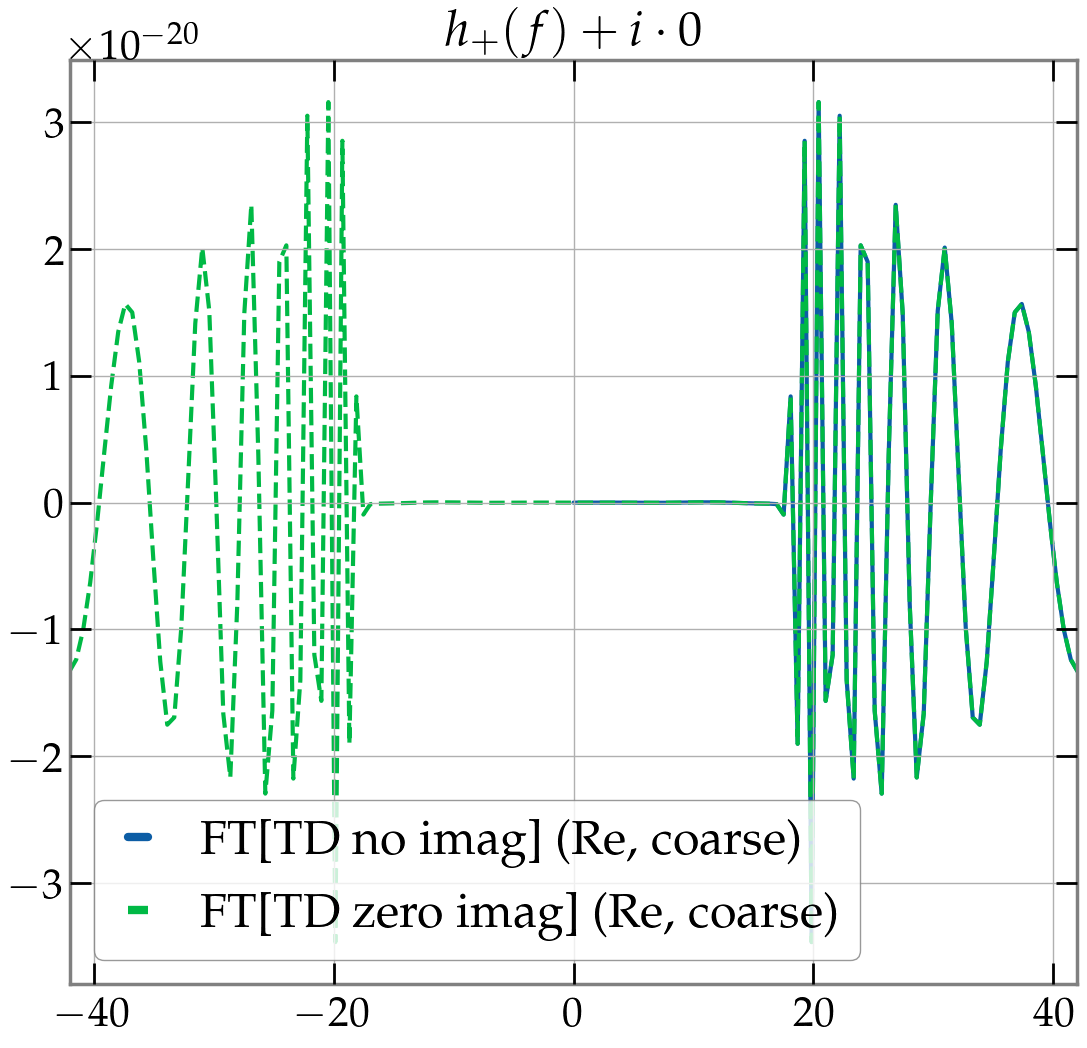

In [33]:
fig, ax = plt.subplots()

ax.plot(hp_t_f_coarse.real, label='FT[TD no imag] (Re, coarse)')
ax.plot(hp_t_complex_f_coarse.real, '--', label='FT[TD zero imag] (Re, coarse)')

# ax.plot(hp_t_f_coarse.imag, label='FT[TD no imag] (Im, coarse)')
# ax.plot(hp_t_complex_f_coarse.imag, '--', label='FT[TD zero imag] (Im, coarse)')

# ax.plot(hp_t_f_coarse.abs(), label='FT[TD no imag] (abs, coarse)')
# ax.plot(hp_t_complex_f_coarse.abs(), '--', label='FT[TD zero imag] (abs, coarse)')

ax.legend()
ax.set_title('$h_+(f) + i \cdot 0$')

# ax.set_xlim([0, 42])
ax.set_xlim([-42, 42])

plt.show()

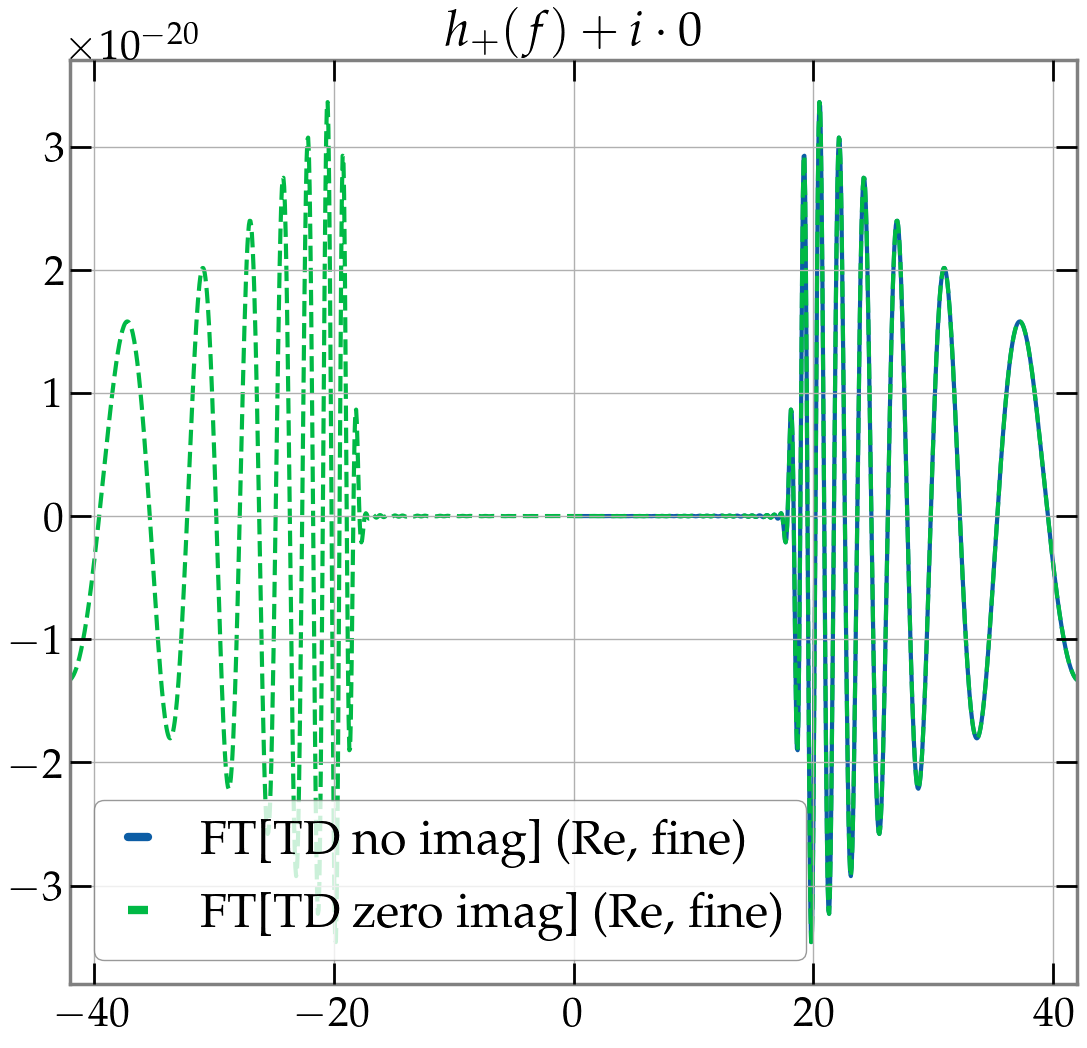

In [34]:
fig, ax = plt.subplots()

ax.plot(hp_t_f_fine.real, label='FT[TD no imag] (Re, fine)')
ax.plot(hp_t_complex_f_fine.real, '--', label='FT[TD zero imag] (Re, fine)')

# ax.plot(hp_t_f_fine.imag, label='FT[TD no imag] (Im, fine)')
# ax.plot(hp_t_complex_f_fine.imag, '--', label='FT[TD zero imag] (Im, fine)')

# ax.plot(hp_t_f_fine.abs(), label='FT[TD no imag] (abs, fine)')
# ax.plot(hp_t_complex_f_fine.abs(), '--', label='FT[TD zero imag] (abs, fine)')

ax.legend()
ax.set_title('$h_+(f) + i \cdot 0$')

# ax.set_xlim([0, 42])
ax.set_xlim([-42, 42])

plt.show()

## Impact of Tapering

To be examined

Hypothesis: causes slight differences of signals coming out of generator and signals in other domain that are converted using our procedures (tapering changes Fourier components slightly, also morphology in time domain)

## Impact of Filtering

### In Frequency Domain

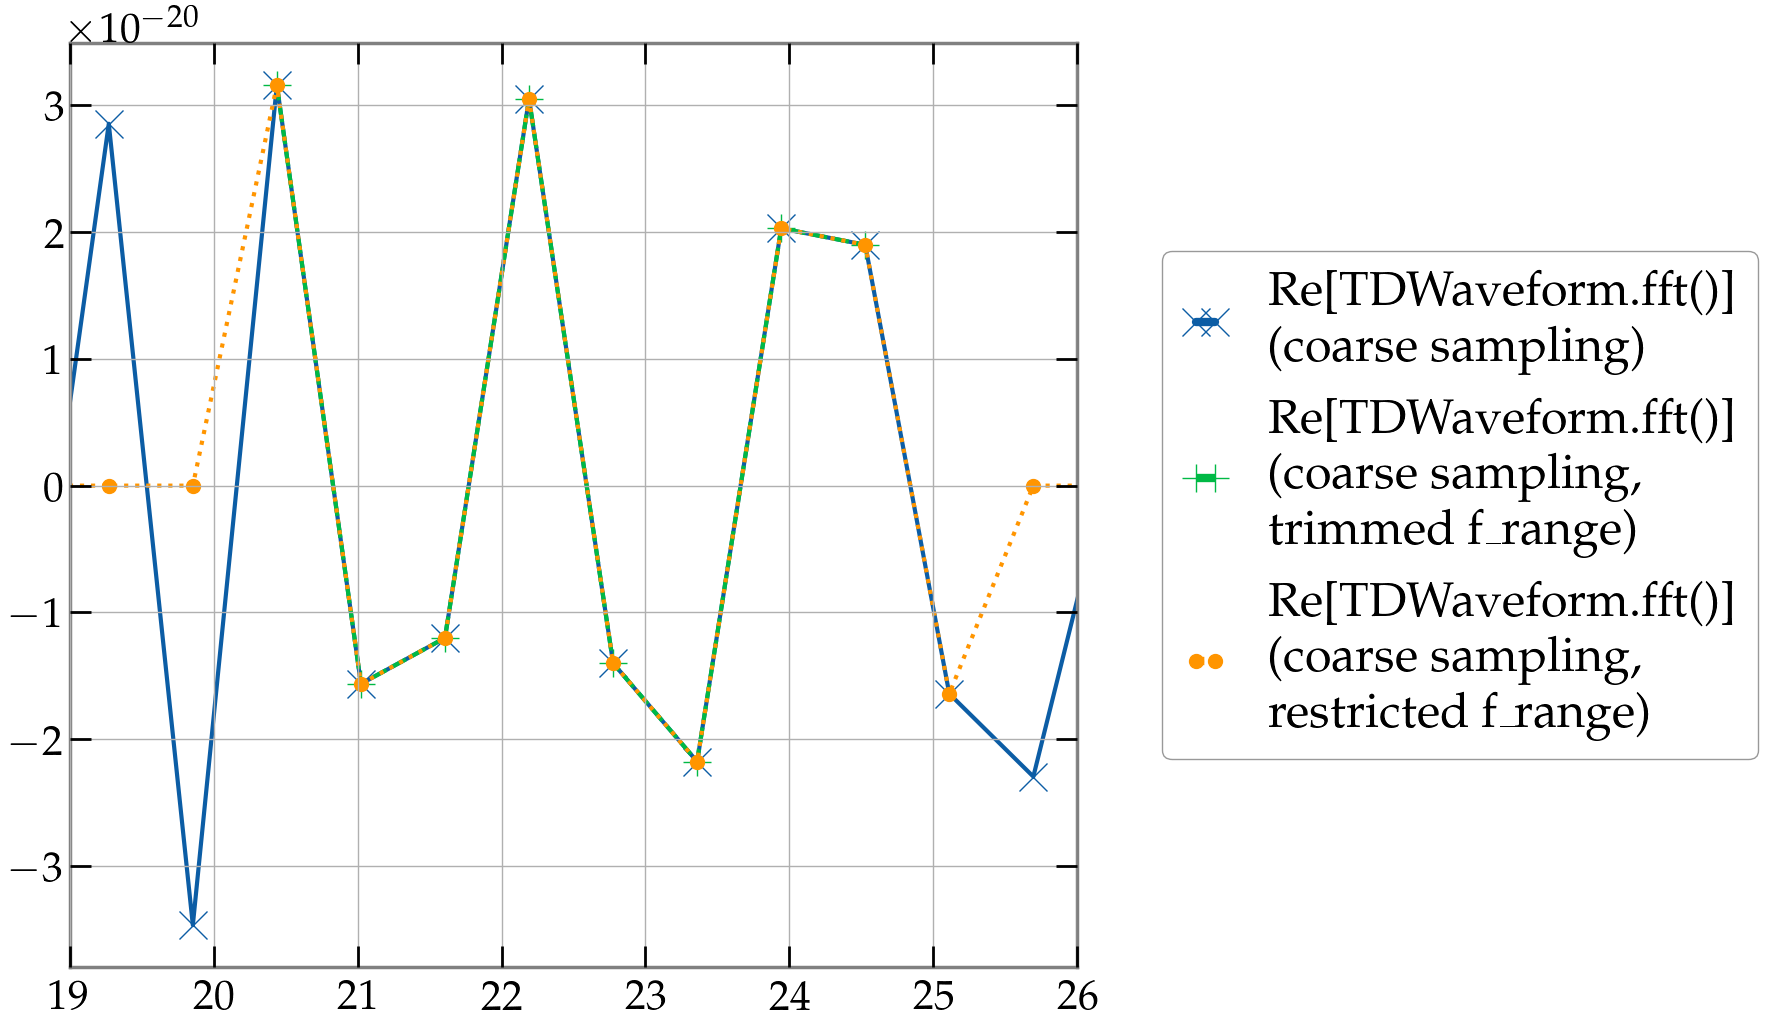

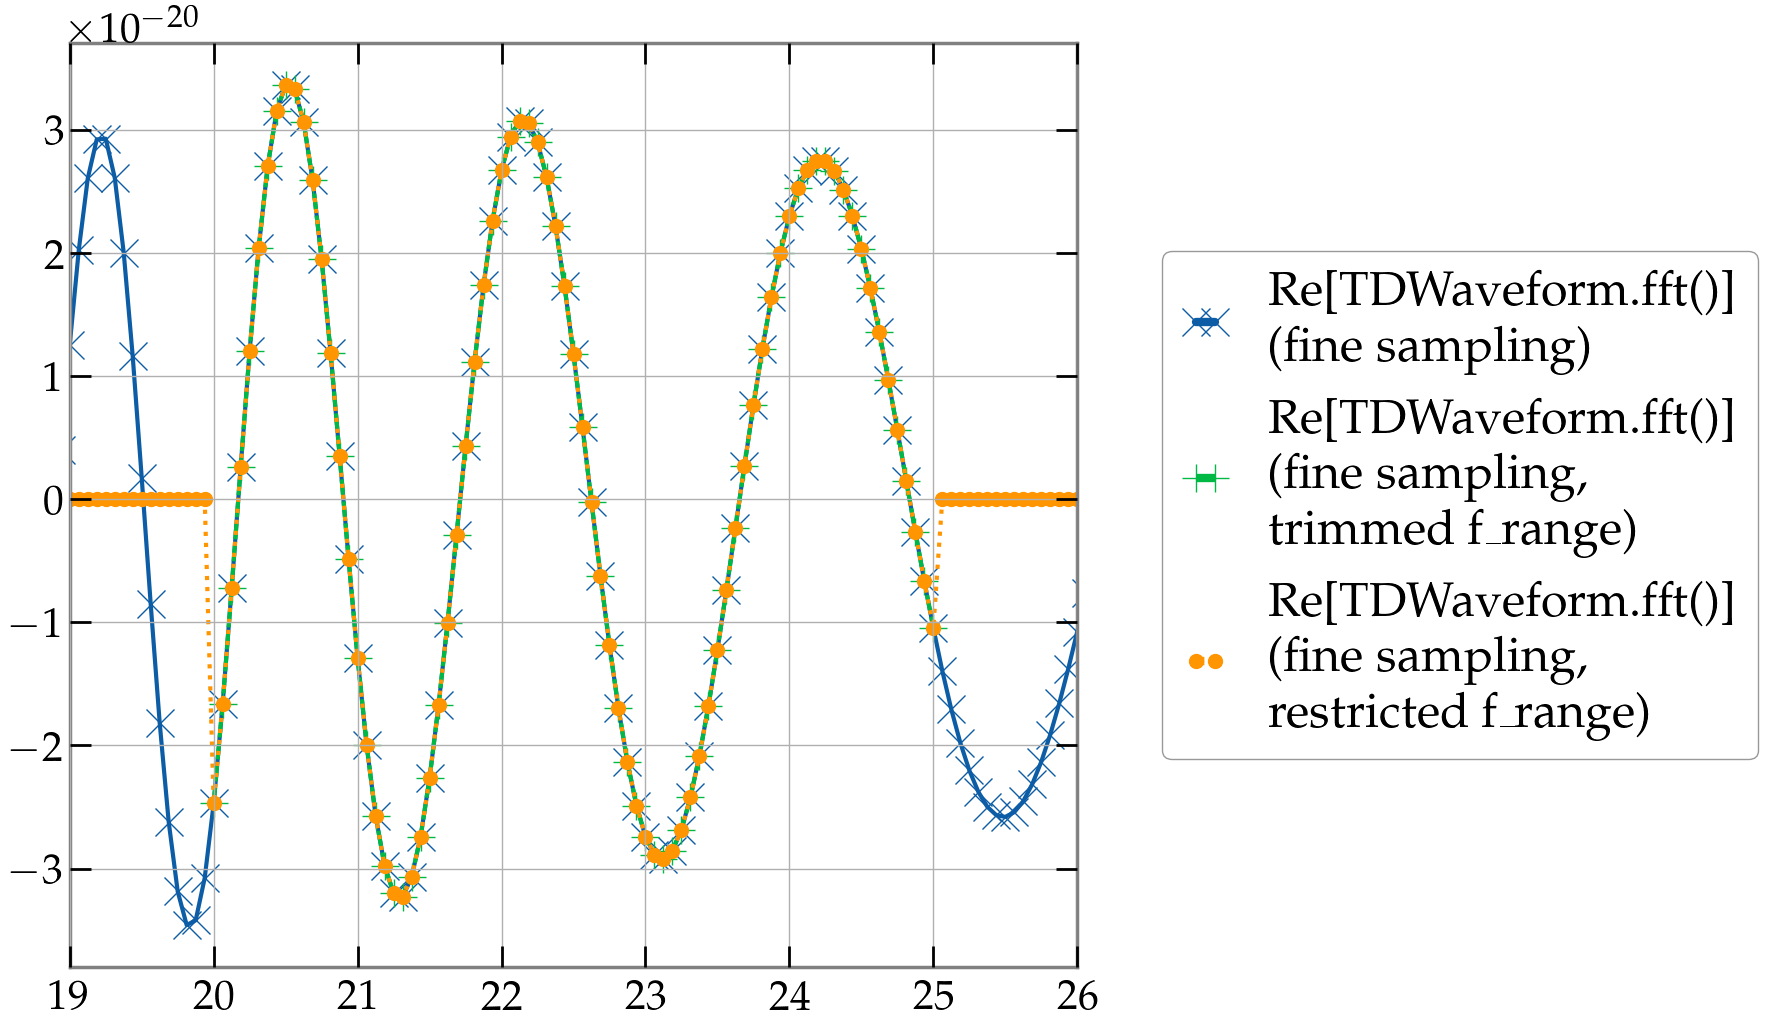

In [35]:
fig,ax = plt.subplots()

ax.plot(hp_t_f_coarse.real, 'x-', label='Re[TDWaveform.fft()]\n(coarse sampling)')

ax.plot(restrict_f_range(hp_t_f_coarse, f_range=[20, 25]).real, '+--', label='Re[TDWaveform.fft()]\n(coarse sampling,\ntrimmed f_range)')

ax.plot(restrict_f_range(hp_t_f_coarse, fill_range=[20, 25]).real, '.:', label='Re[TDWaveform.fft()]\n(coarse sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])
ax.set_xlim([19.0, 26])

plt.show()


fig,ax = plt.subplots()

ax.plot(hp_t_f_fine.real, 'x-', label='Re[TDWaveform.fft()]\n(fine sampling)')

ax.plot(restrict_f_range(hp_t_f_fine, f_range=[20, 25]).real, '+--', label='Re[TDWaveform.fft()]\n(fine sampling,\ntrimmed f_range)')

ax.plot(restrict_f_range(hp_t_f_fine, fill_range=[20, 25]).real, '.:', label='Re[TDWaveform.fft()]\n(fine sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])
ax.set_xlim([19.0, 26.0])
# ax.set_xlim([19.9, 20.1])

plt.show()

Does exactly what it should do: setting frequency components out of range to zero while leaving other samples untouched

Now testing what happens with upper_cut=True, if it has same range as setting to zero

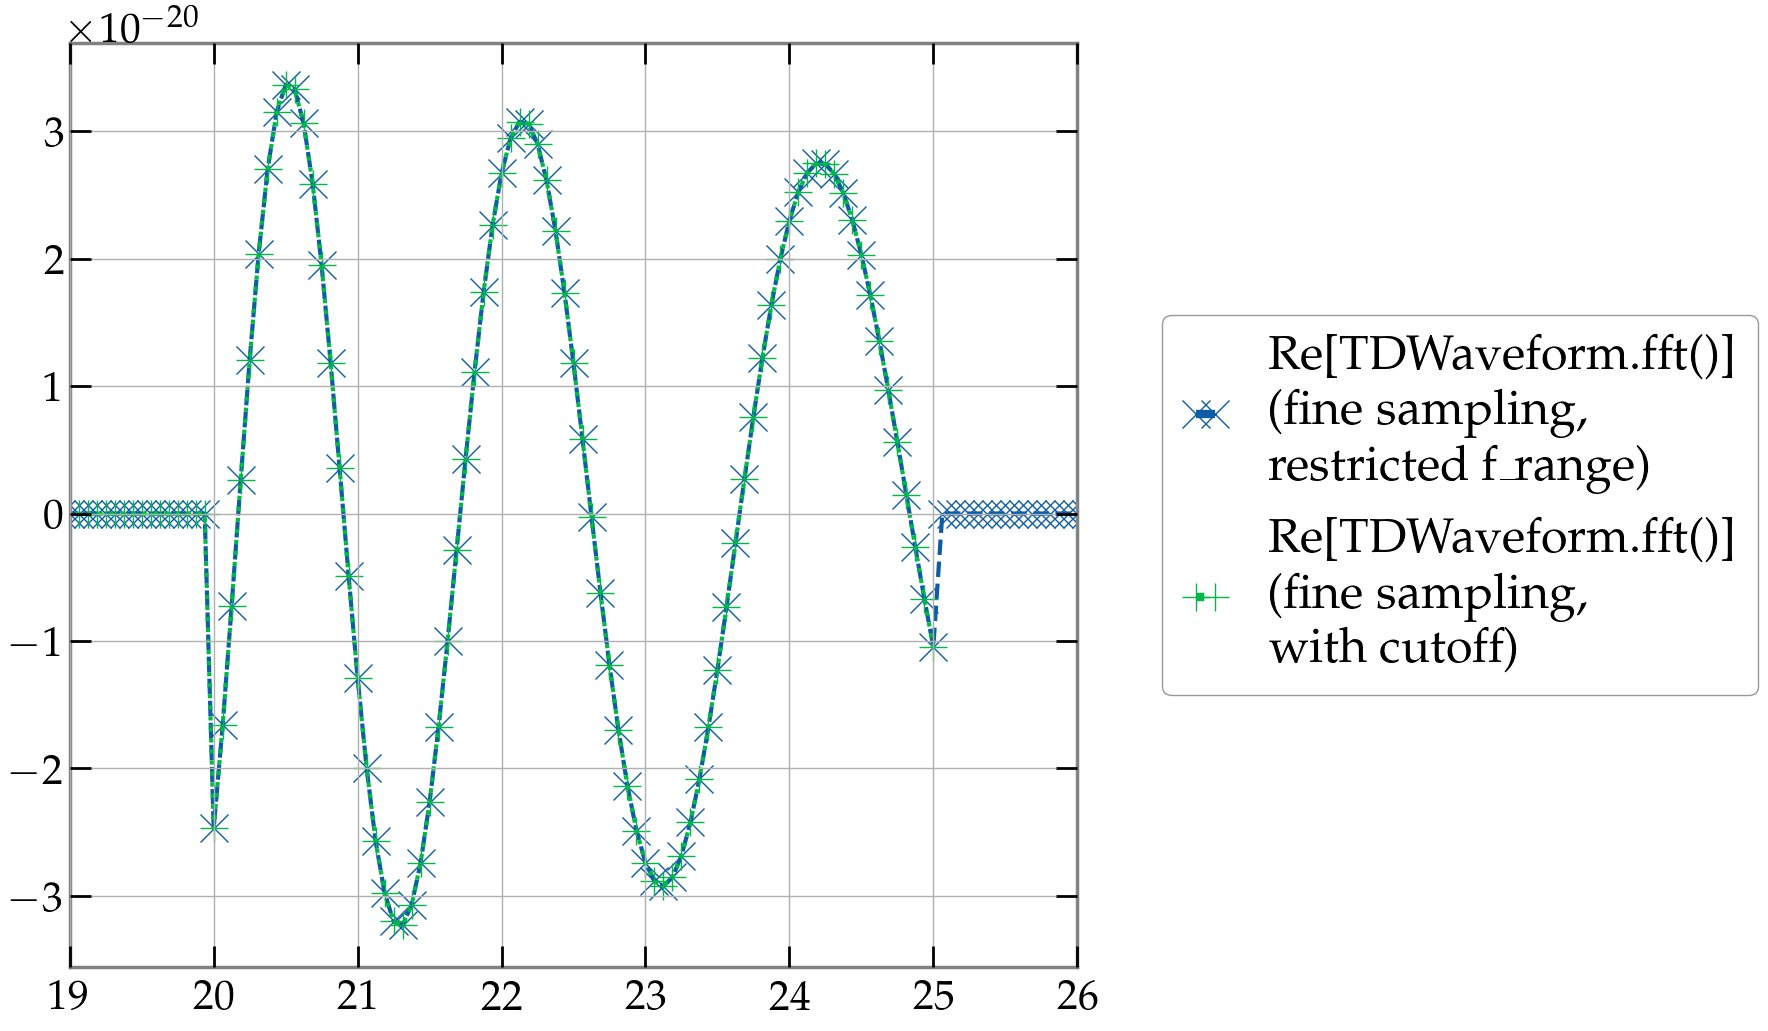

In [36]:
fig,ax = plt.subplots()

ax.plot(restrict_f_range(hp_t_f_fine, fill_range=[20, 25]).real, 'x--', label='Re[TDWaveform.fft()]\n(fine sampling,\nrestricted f_range)')

ax.plot(restrict_f_range(hp_t_f_fine, f_range=[None, 25], fill_range=[20, None]).real, '+:', label='Re[TDWaveform.fft()]\n(fine sampling,\nwith cutoff)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])
ax.set_xlim([19.0, 26.0])
# ax.set_xlim([19.9, 20.1])

plt.show()

### In Time Domain

In [37]:
hp_t_coarse_filtered = fd_to_td_waveform(hp_t_f_coarse, f_range=[f_min, None])
hp_t_fine_filtered = fd_to_td_waveform(hp_t_f_fine, f_range=[f_min, None])

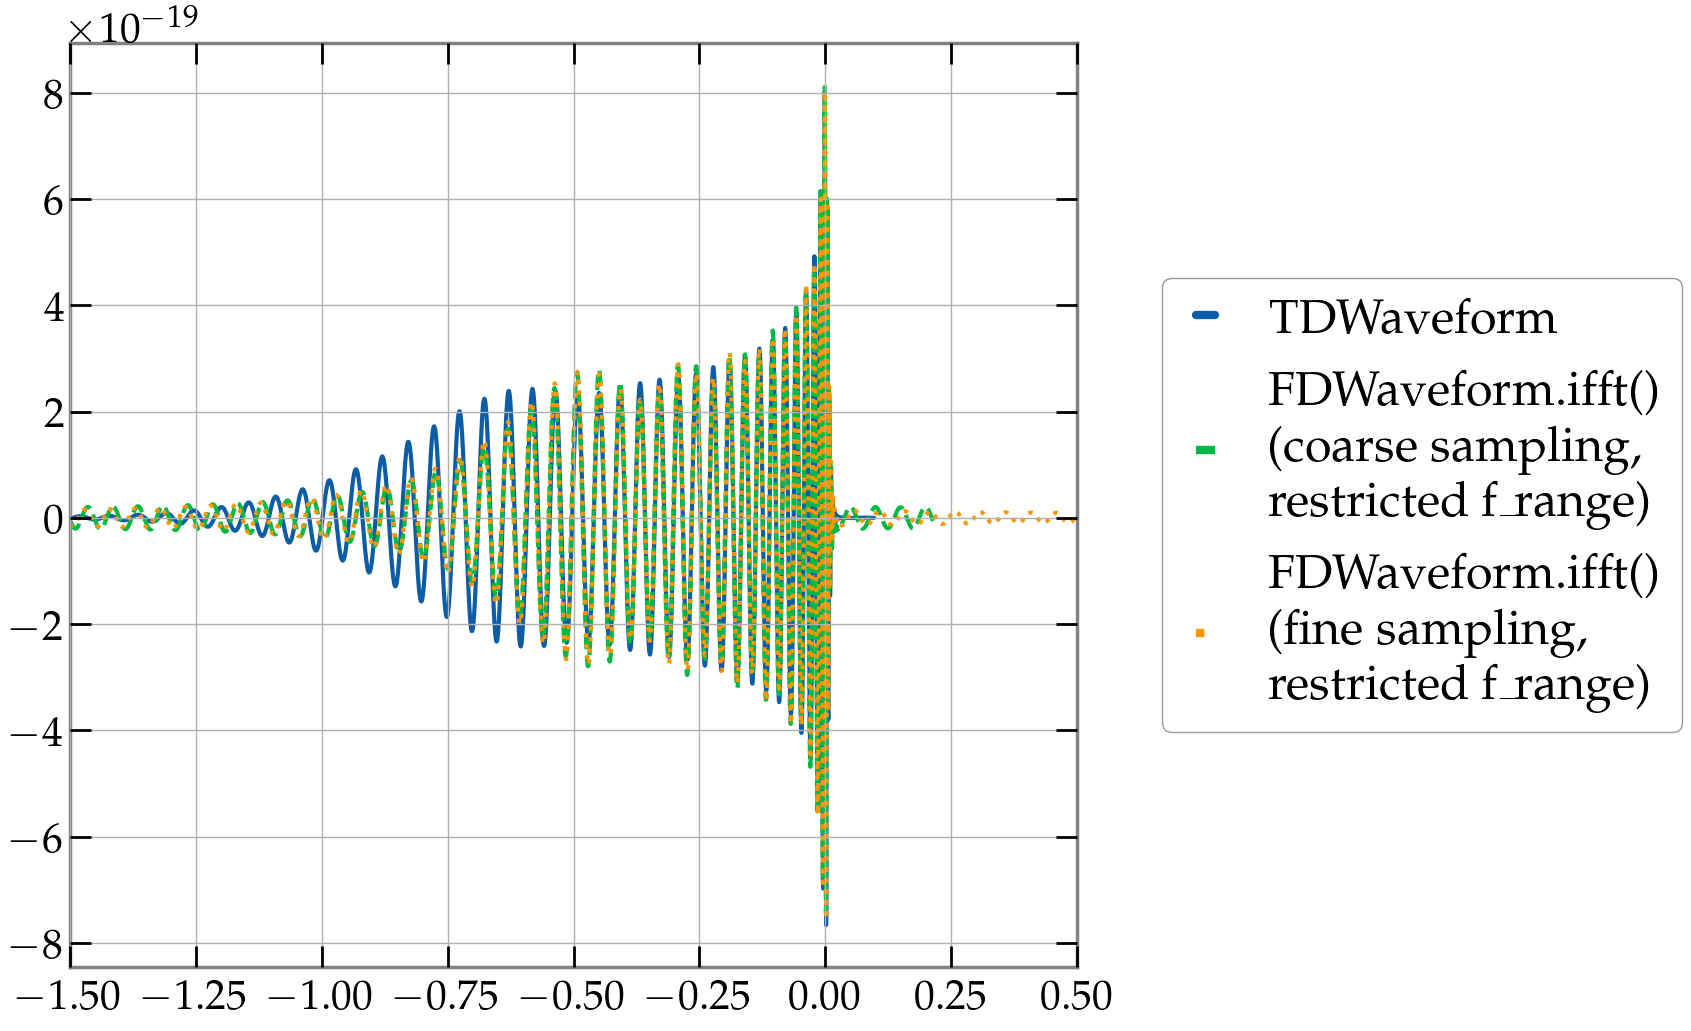

In [38]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_coarse_filtered, '--', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend()
ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-1.5, 0.5])

plt.show()

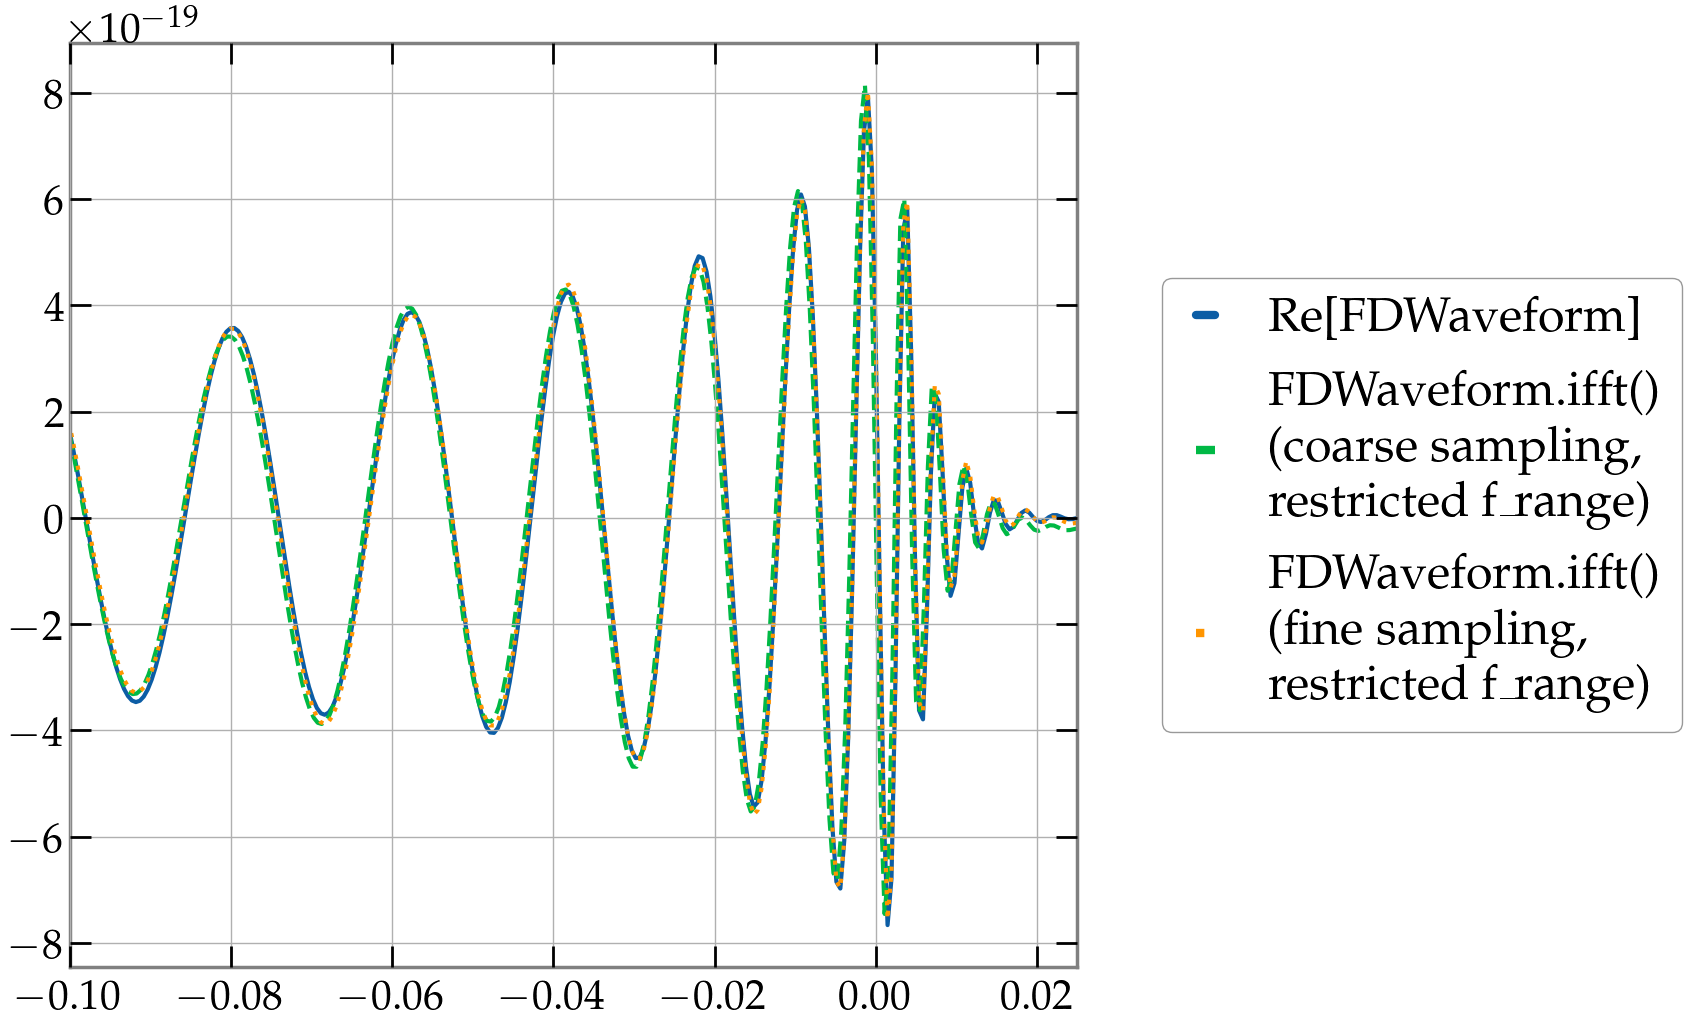

In [39]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='Re[FDWaveform]')

ax.plot(hp_t_coarse_filtered, '--', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-0.1, 0.025])

plt.show()

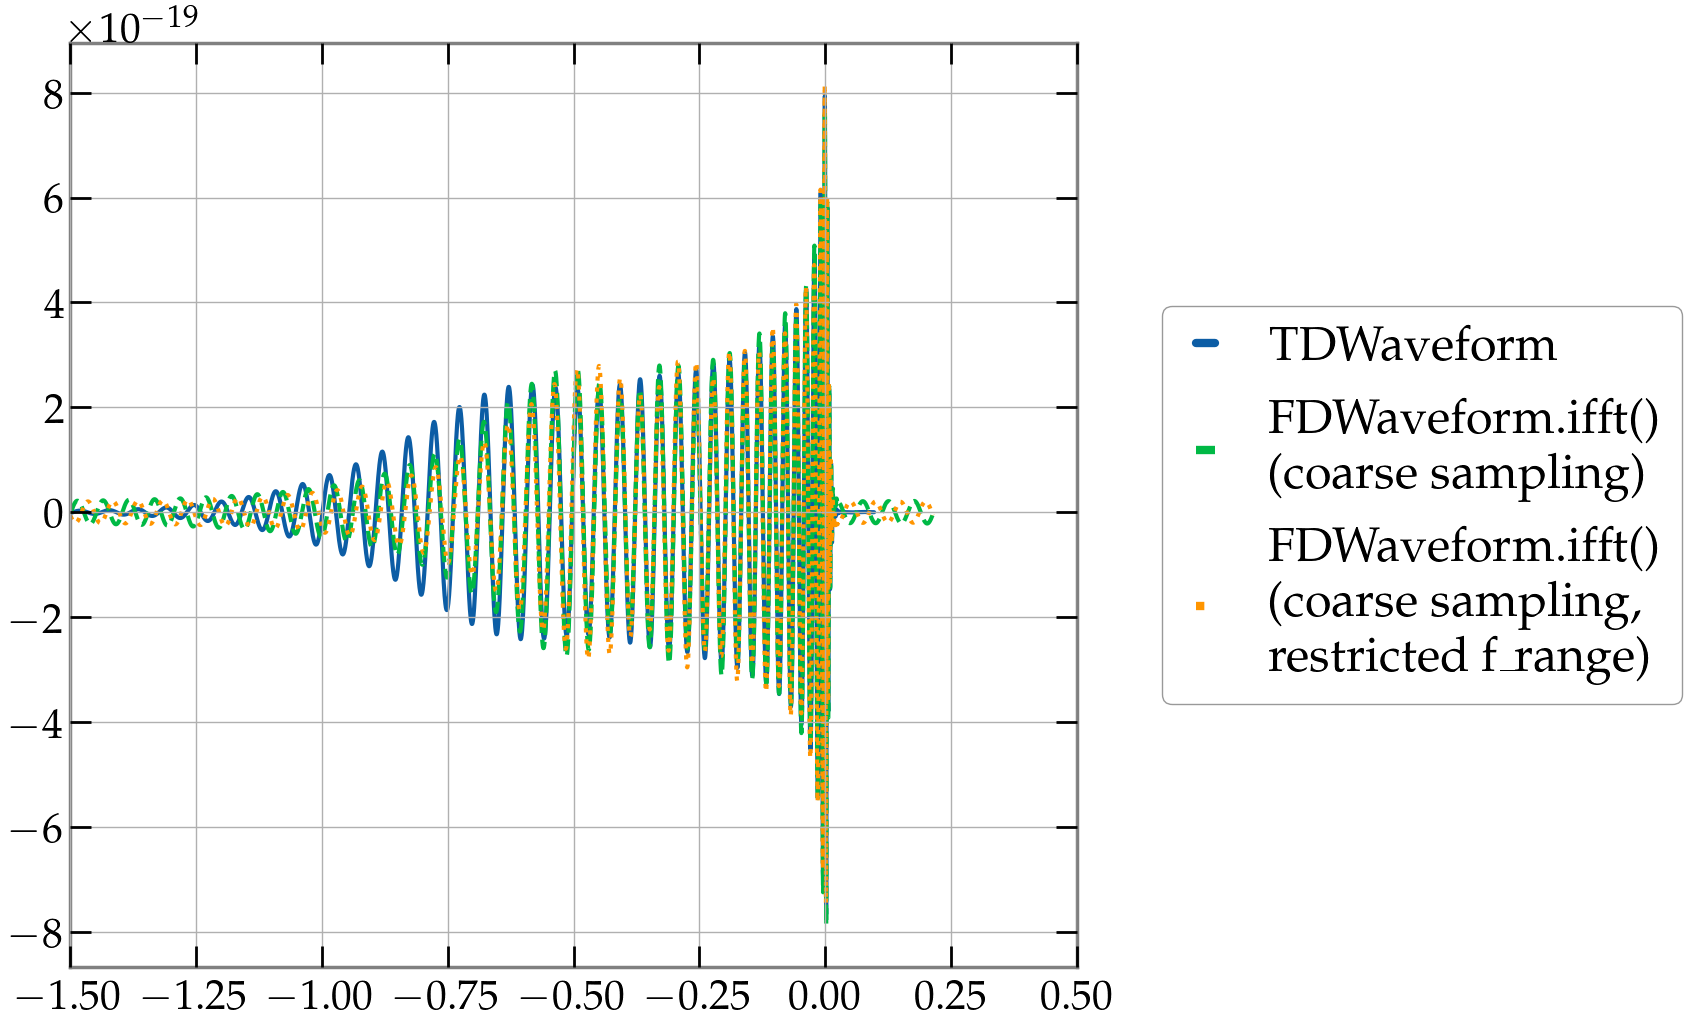

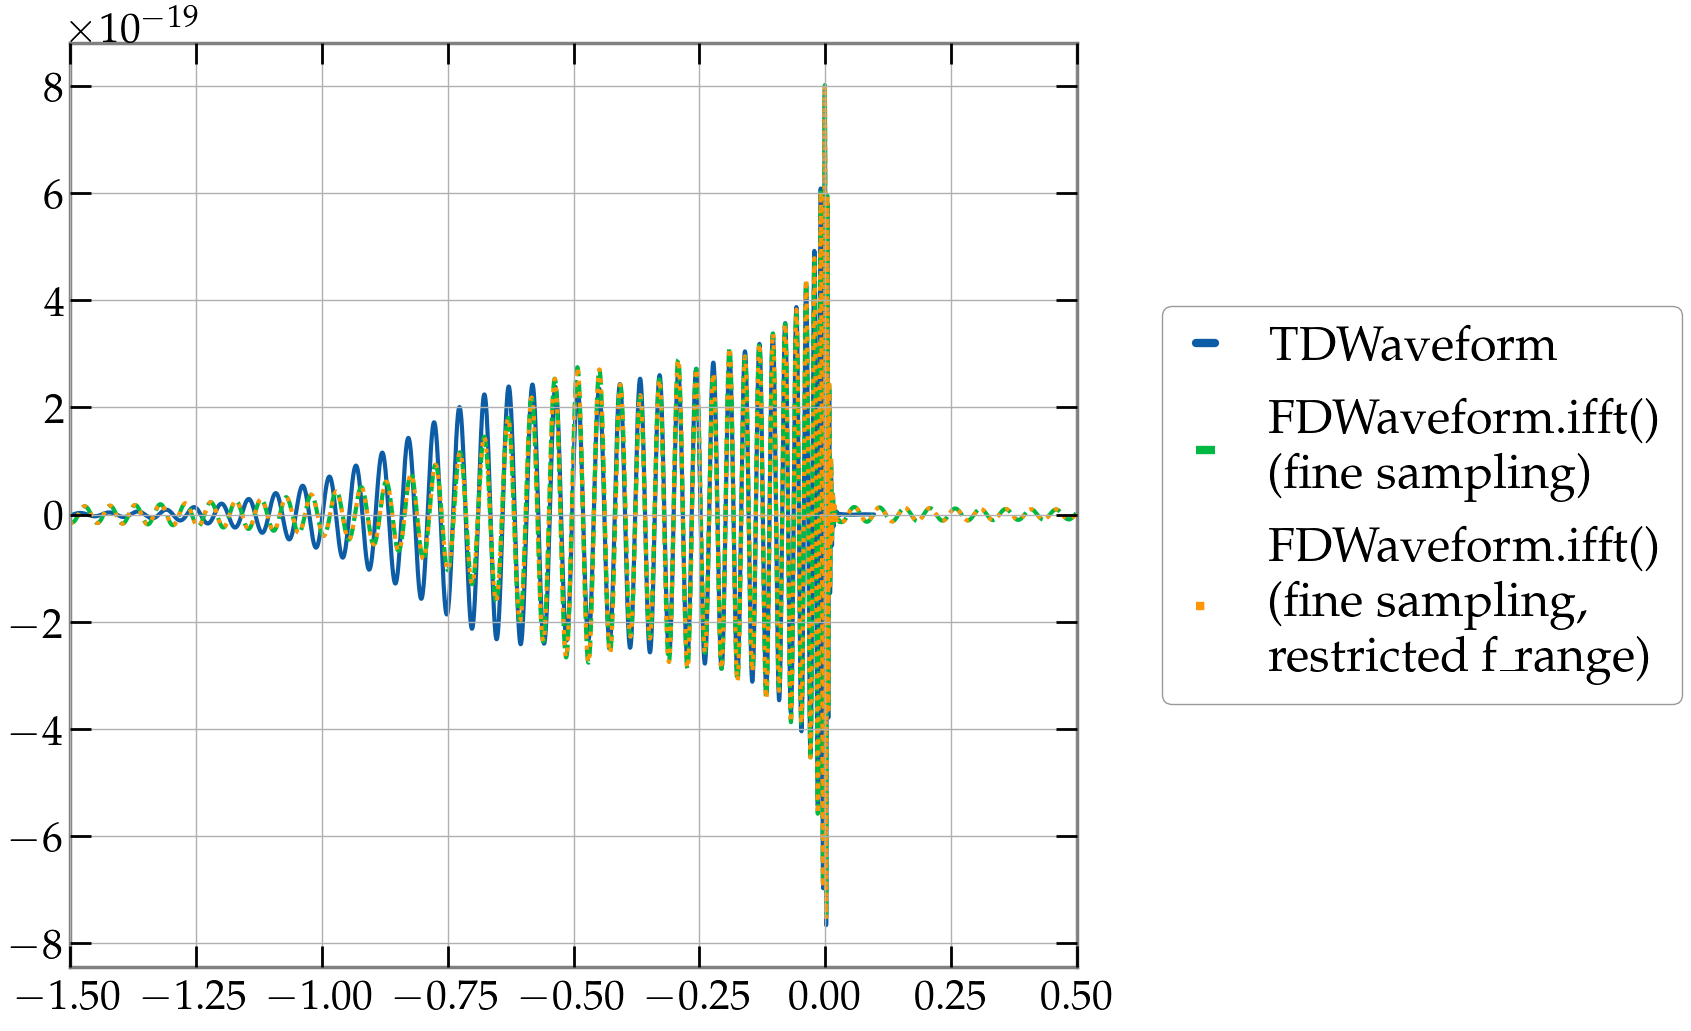

In [40]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_t_coarse_filtered, ':', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-1.5, 0.5])

plt.show()



fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_fine, '--', label='FDWaveform.ifft()\n(fine sampling)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-1.5, 0.5])

plt.show()

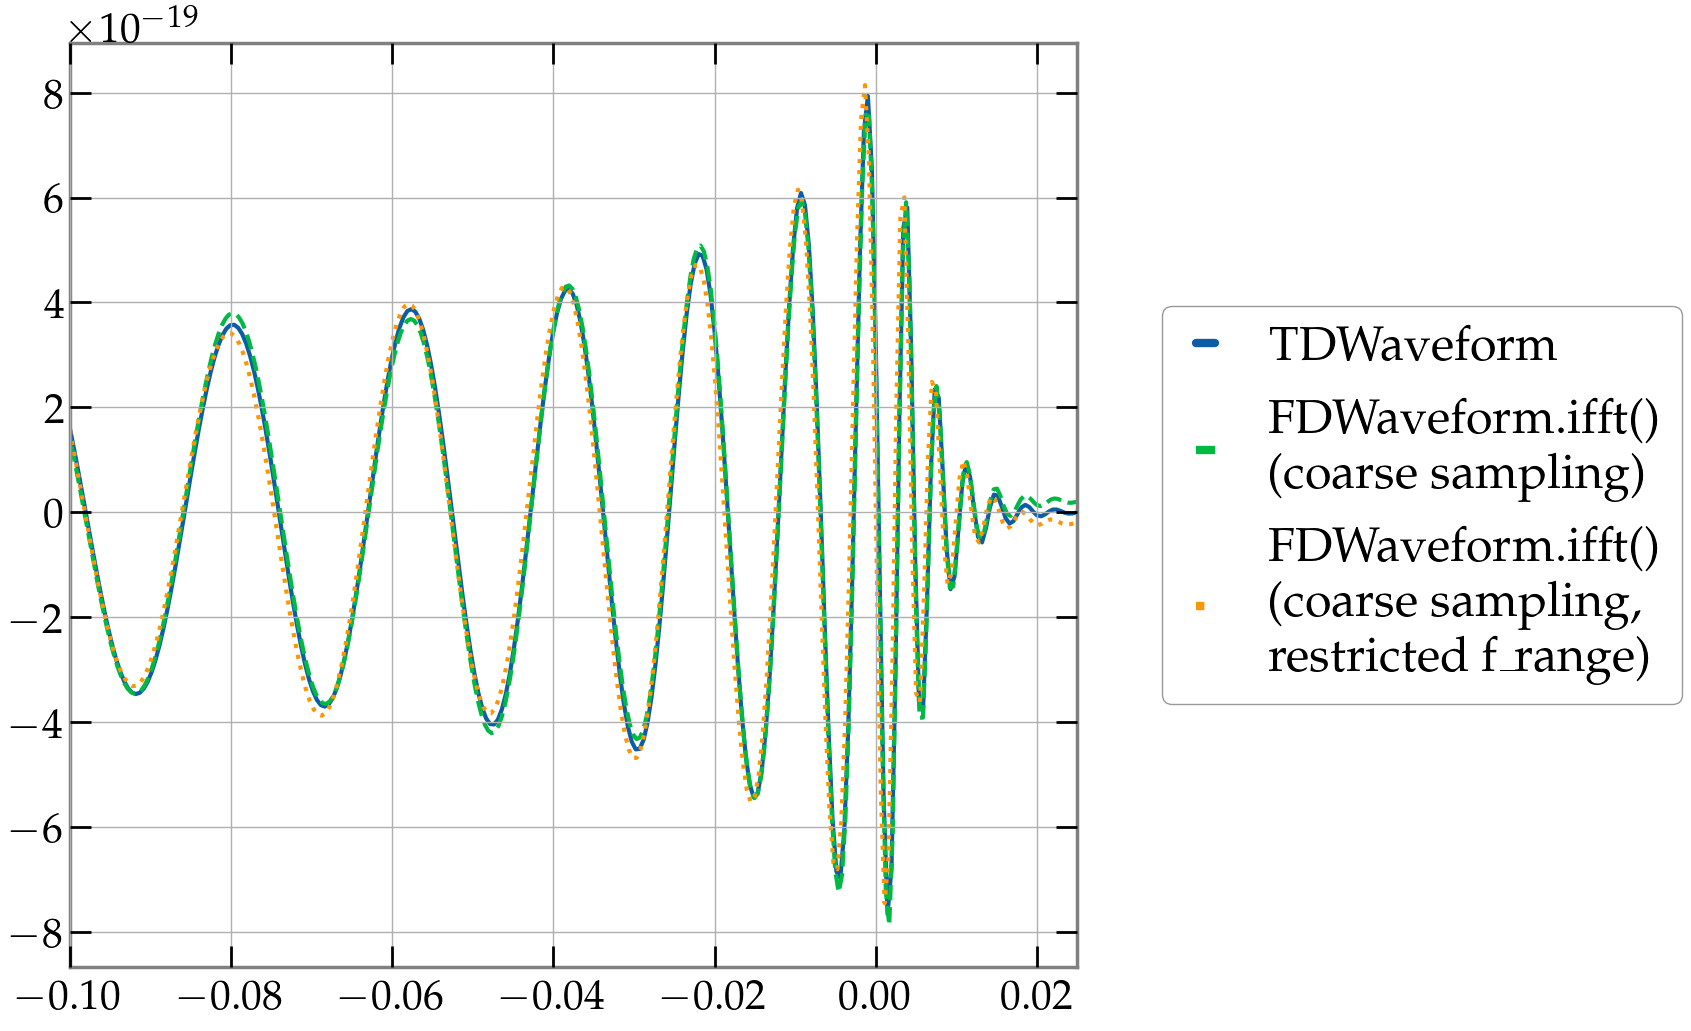

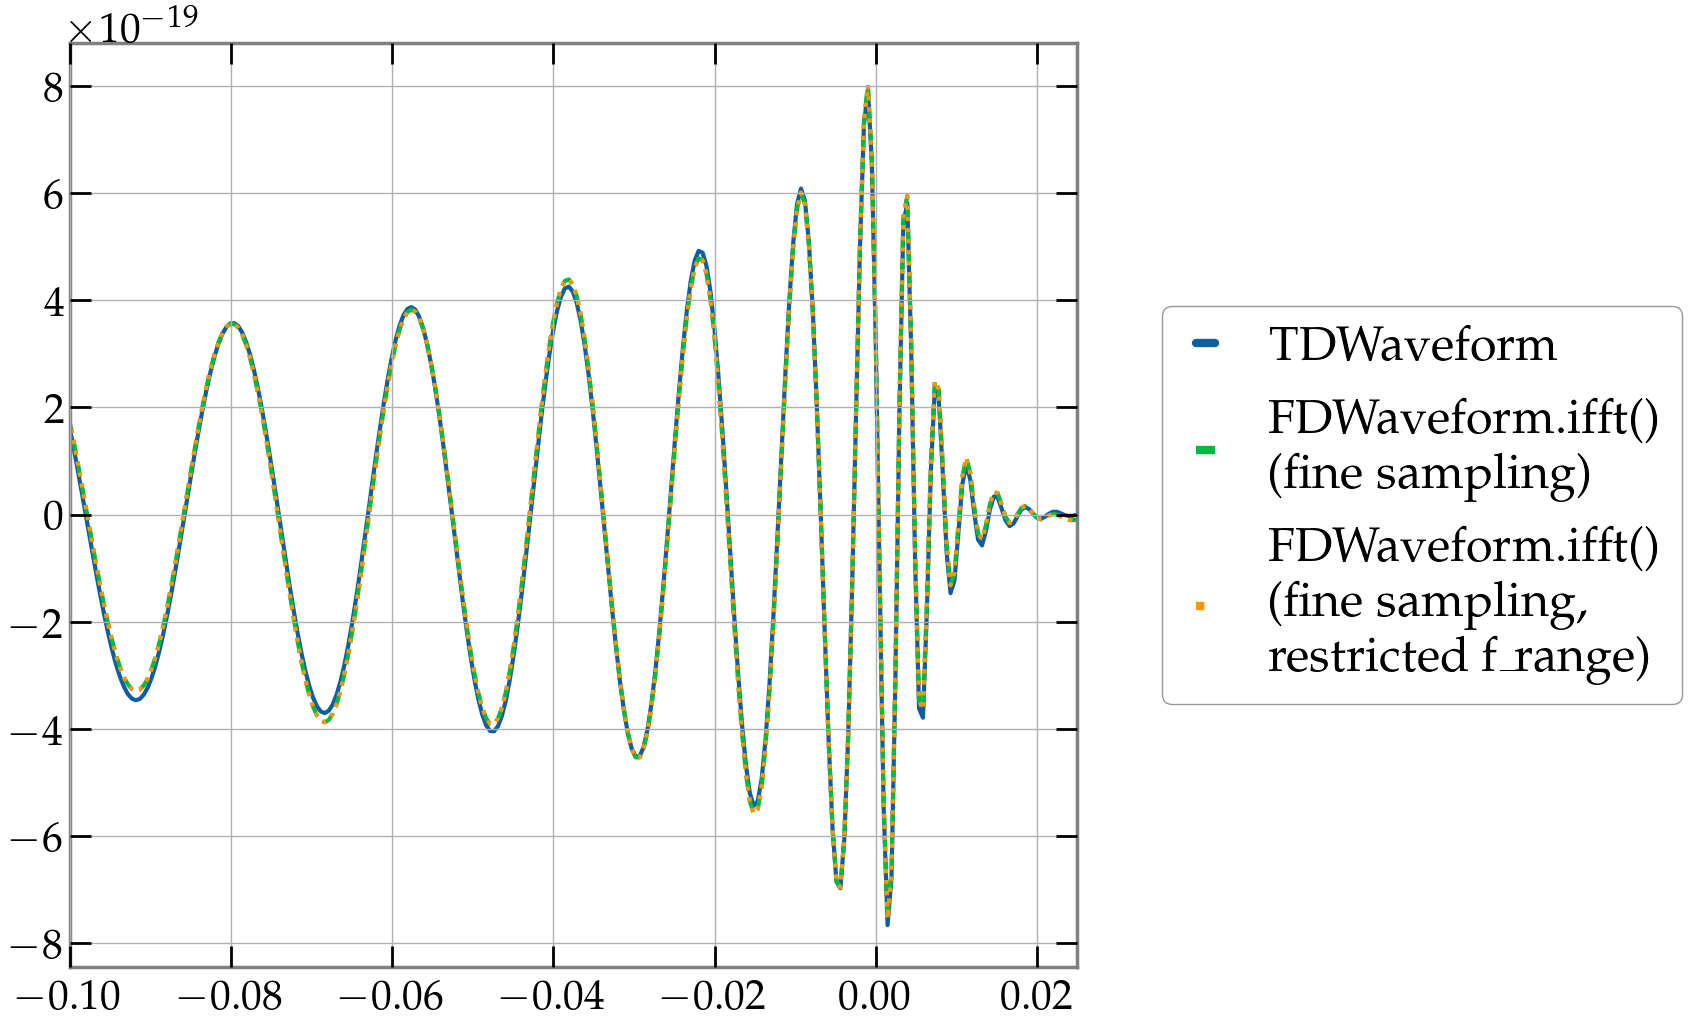

In [41]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_t_coarse_filtered, ':', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-0.1, 0.025])

plt.show()



fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_fine, '--', label='FDWaveform.ifft()\n(fine sampling)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-0.1, 0.025])

plt.show()

Clearly, removing some Fourier components and thus information has an impact on the Fourier transform of the coarsely sampled signal. For fine sampling, this impact is negligible.

Generally speaking, filtering also increases the phase shift observed most prominently at the beginning of the signal.

## Impact of Padding

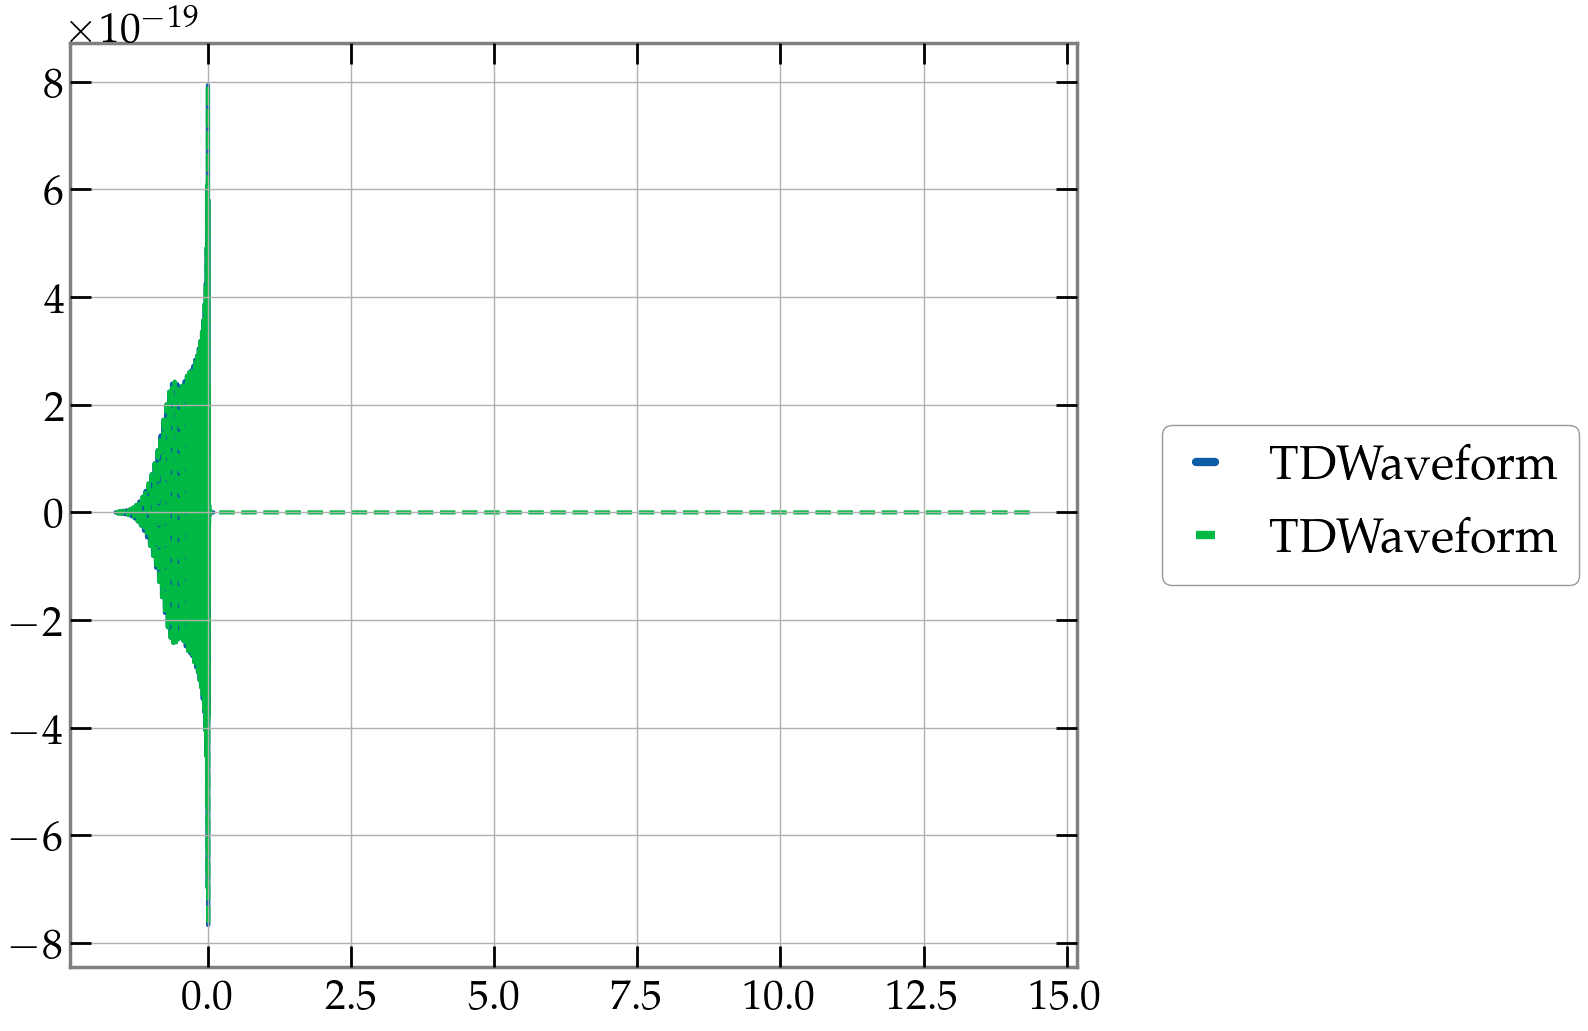

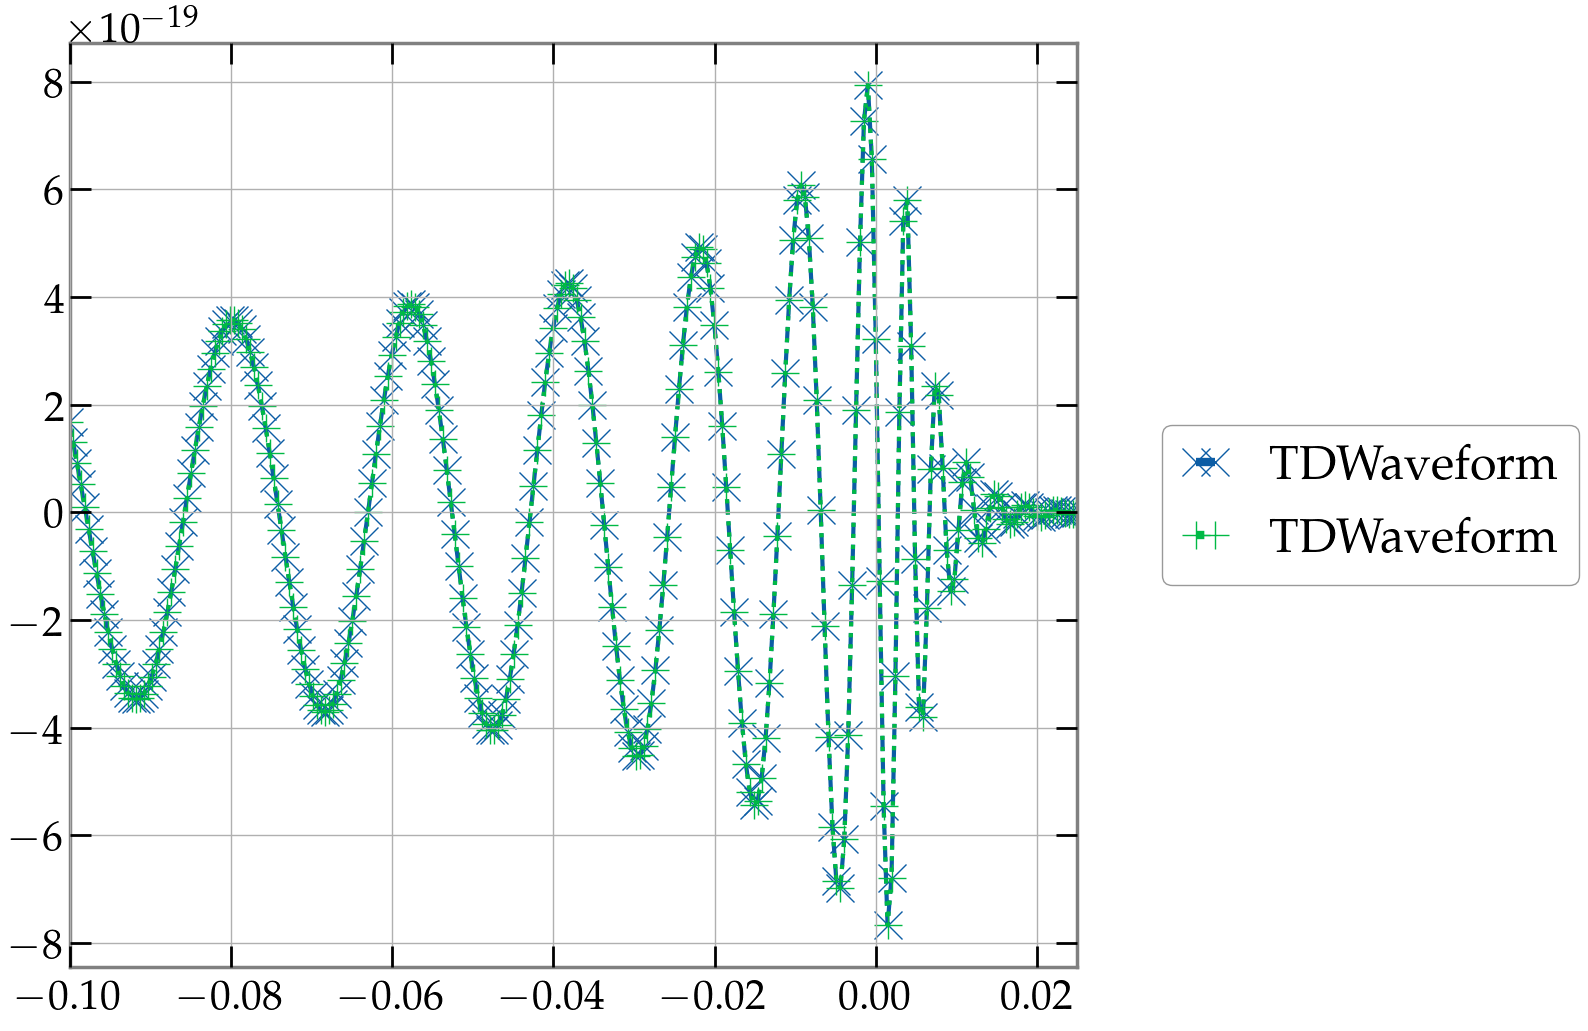

In [42]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(pad_to_get_target_df(hp_t, df=0.0625 * u.Hz), '--', label='TDWaveform')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

plt.show()



fig, ax = plt.subplots()

ax.plot(hp_t, 'x--', label='TDWaveform')

ax.plot(pad_to_get_target_df(hp_t, df=0.0625), '+:', label='TDWaveform')  # Input without unit works as well

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

# ax.set_xlim([-1.5, 0.5])
ax.set_xlim([-0.1, 0.025])

plt.show()

Does exactly what it should do: increasing sample size by adding zeros after end of signal while leaving other samples untouched

## Impact of Interpolating

Deal with get_signal_at_target_df

## Mass Scaling Verifications

In [43]:
from gw_signal_tools.waveform_utils import (
    rescale_with_Mtotal, scale_to_Mtotal, get_mass_scaled_wf
)
import astropy.constants as const

In [44]:
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
delta_f = 2**-4 * u.Hz
# delta_f = 2**-5 * u.Hz
# delta_f = 2**-6 * u.Hz
delta_t = 1.0/4096.0 * u.s
# delta_t = 1.0/8192.0 * u.s
f_ref = 20.*u.Hz  # Frequency where we specify spins
distance = 440.*u.Mpc
inclination = 2.7*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


# Define the approximant
approximant = 'IMRPhenomXPHM'

# Initialize the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)



M_center = 42.*u.solMass
# M_center = 60.*u.solMass
# M_center = 100.*u.solMass

eta_const = 0.05*u.dimensionless_unscaled
# eta_const = 0.15*u.dimensionless_unscaled  # Not too different here

# q_const = 0.5*u.dimensionless_unscaled


# mass1, mass2 = m1_m2_of_M_eta(M_center, eta_const)  # Not needed at the moment

wf_center_parameters = {
    'total_mass': M_center,  # When default_dict behaviour was changed
    'sym_mass_ratio': eta_const,  # When default_dict behaviour was changed
    # 'mass_ratio': q_const,  # When default_dict behaviour was changed
    # 'mass1' : mass1,
    # 'mass2' : mass2,
    'f22_start' : f_min,
    'f_max' : f_max,
    'deltaT' : delta_t,
    'deltaF' : delta_f,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
}

hp_t_center, _ = wfm.GenerateTDWaveform(wf_center_parameters, gen)

hp_f_center, _ = wfm.GenerateFDWaveform(wf_center_parameters, gen)

# psd_no_noise = restrict_f_range(psd_no_noise, f_range=[f_min, f_max]).interpolate(delta_f.value)


waveforms_list = []
distances_1 = []
distances_2 = []

# M_list = u.Quantity(M_center.value + np.linspace(-0.1 * M_center.value, 0.1 * M_center.value, num=42), u.solMass)

# M_list = u.Quantity(M_center.value + np.linspace(-0.1 * M_center.value, 0.1 * M_center.value, num=196), u.solMass)
# M_list = u.Quantity(np.arange(0.9 * M_center.value, 1.1 * M_center.value, step=0.001 * M_center.value), u.solMass)  # Make sure that M_center is included
M_list = u.Quantity(np.arange(0.9 * M_center.value, 1.1 * M_center.value, step=0.0005 * M_center.value), u.solMass)  # Make sure that M_center is included

# M_list = u.Quantity(M_center.value + np.linspace(-0.2 * M_center.value, 0.2 * M_center.value, num=196), u.solMass)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/utils.py:277: UserWarning: The larger object cannot be determined, assuming m1 >= m2.
  warnings.warn(warn_string)
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWavefo

In [45]:
Msun_to_kg = const.M_sun / u.Msun
kg_to_Msun = 1.0 / Msun_to_kg

kg_to_s = const.G / const.c**3
s_to_kg = 1.0 / kg_to_s

# M_center_in_s = M_center.to('kg') * kg_to_s
M_center_in_s = M_center * Msun_to_kg * kg_to_s  # Equivalent

### Frequency Domain

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

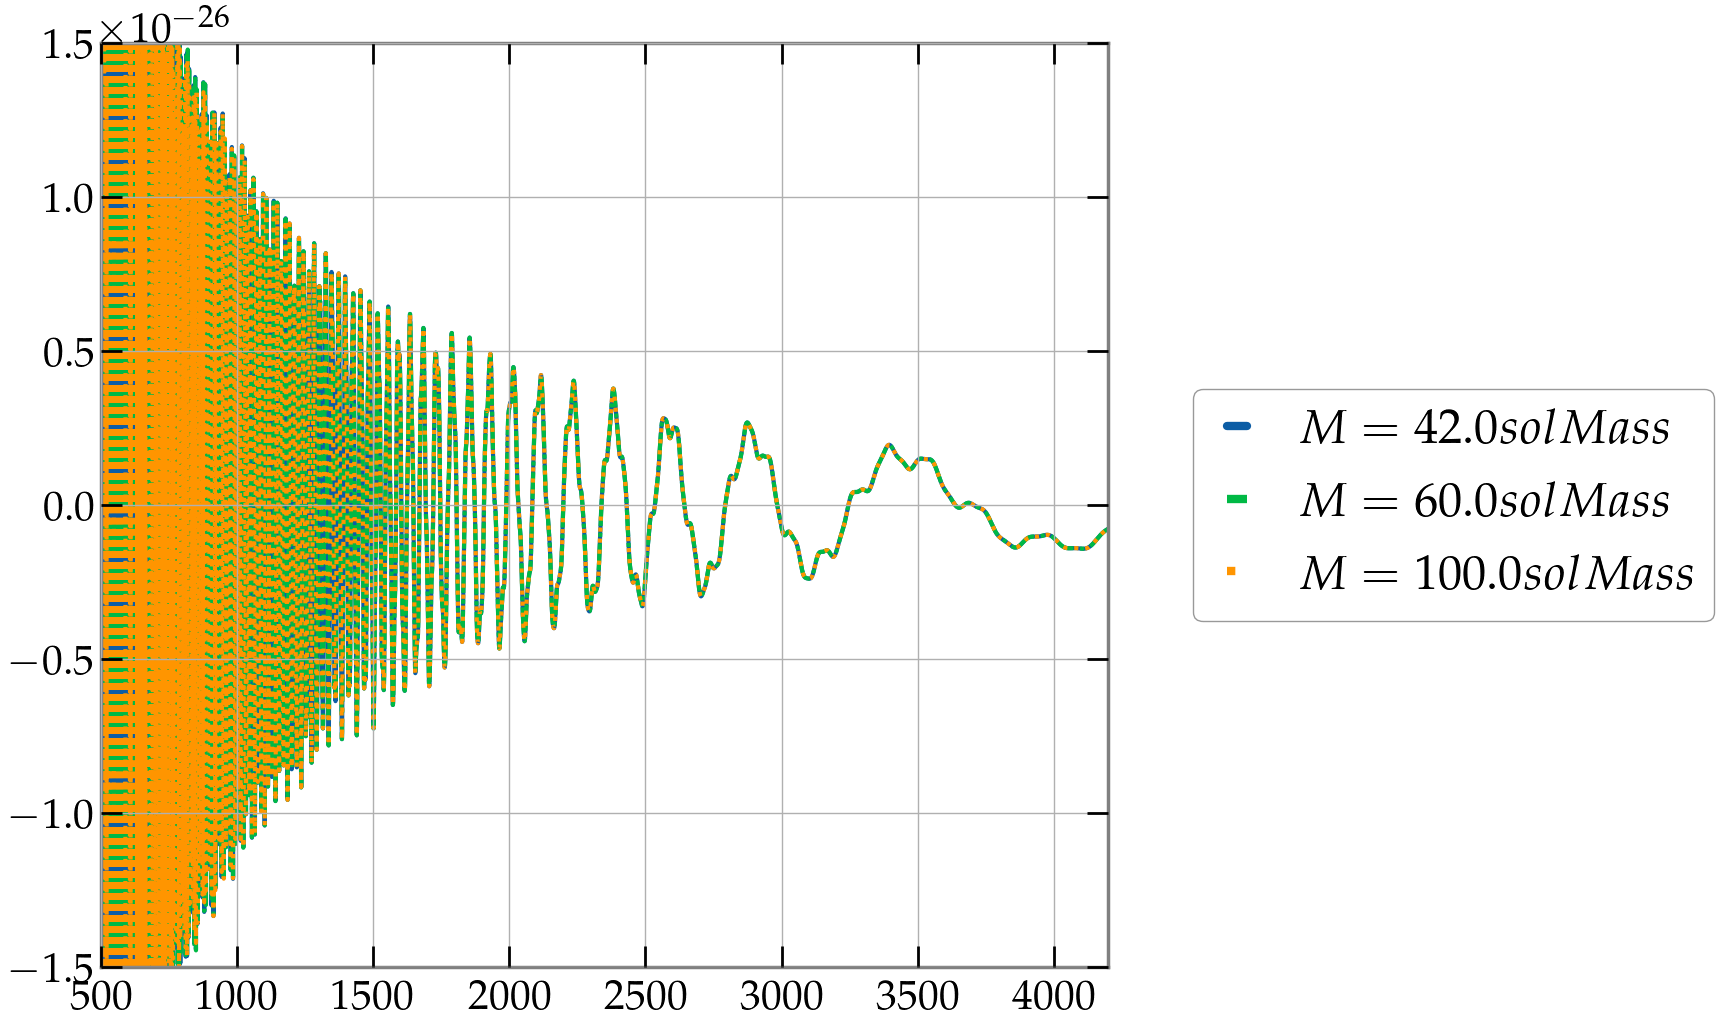

In [46]:
linestyles = ['-', '-.', ':']
# linestyles = ['x--', '+--', '.--']

for i, M in enumerate(u.Quantity([42.0, 60.0, 100.0], u.solMass)):
    M_in_s = M * Msun_to_kg * kg_to_s

    hp_f, _ = wfm.GenerateFDWaveform(
        wf_center_parameters | {
            'total_mass': M,
            'f22_start': f_min / M.value,  # Adjust so that we have good frequency range after multiplication
            # 'f_max' : f_max / M.value,  # Adjust so that we have good frequency range after multiplication
            # 'deltaF' : delta_f / M.value,  # Kernel dies when trying to run this
            'deltaF' : 2**-8*u.Hz,
            'f22_ref': f_ref / M.value  # Does not play a role -> IT DOES
        },
        gen
    )

    hp_f /= M**2
    hp_f.frequencies *= M
    
    plt.plot(np.real(hp_f), linestyles[i], label=f'$M = {M}$')
    # plt.plot(np.imag(hp_f), ls=linestyles[i], label=f'$M = {M}$')
    # plt.plot(np.abs(hp_f), '--', , label=f'$M = {M}$')

plt.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

plt.xlim([5 * M.value, 42 * M.value])
# plt.xlim([8 * M.value, 10 * M.value])  # Zoom in on start
# plt.xlim([15 * M.value, 24 * M.value])  # Zoom in
# plt.xlim([24 * M.value, 24.01 * M.value])  # Zoom in for single points
plt.ylim([-1.5e-26, 1.5e-26])

    
plt.show()

Perhaps better to use function

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

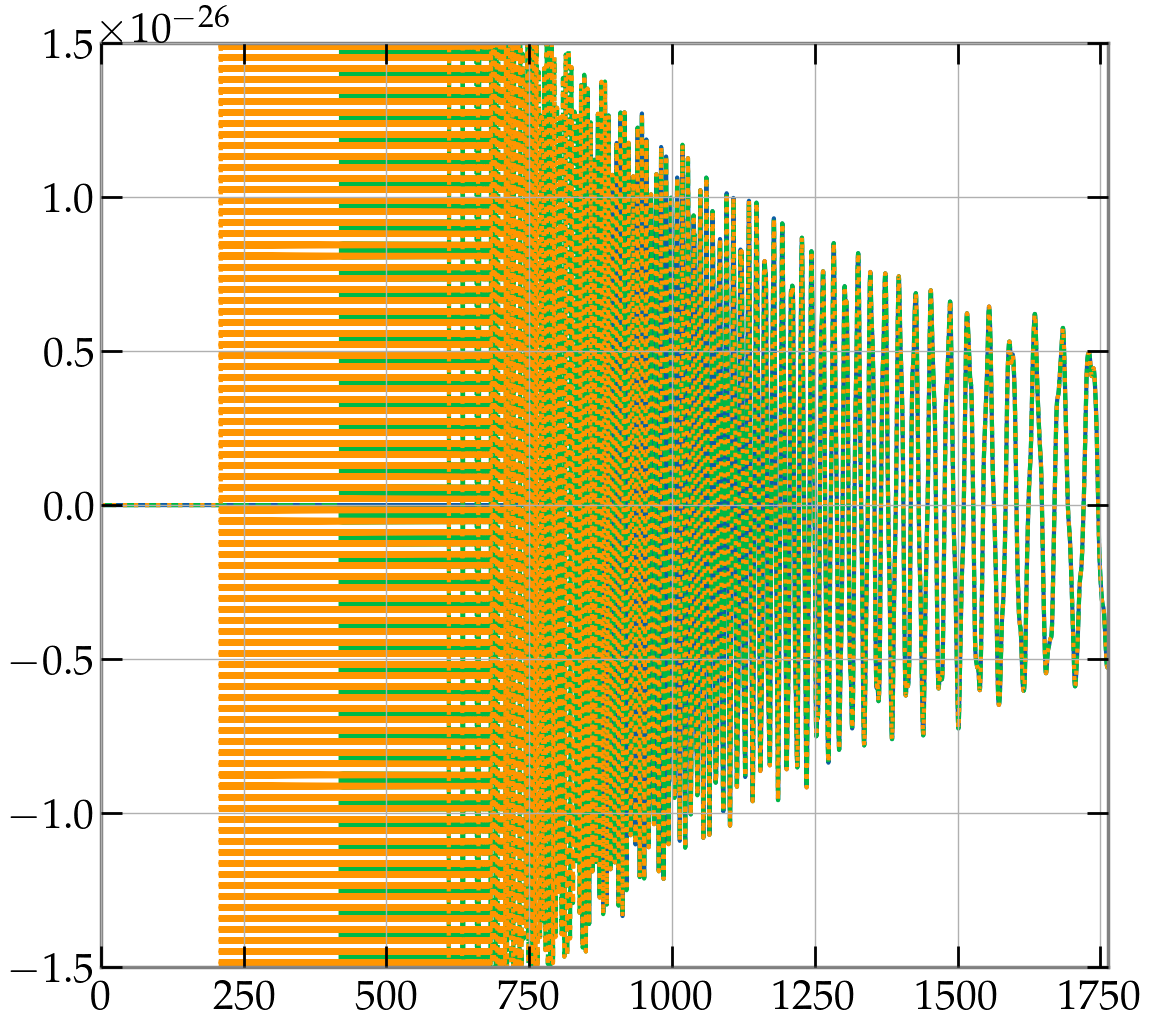

In [47]:
mass1 = M_center
mass2 = 0.5 * M_center
mass3 = 0.25 * M_center

h1 = get_mass_scaled_wf(wf_center_parameters | {'total_mass': mass1, 'deltaF': 2**-8 * u.Hz}, 'FD', gen)
h2 = get_mass_scaled_wf(wf_center_parameters | {'total_mass': mass2, 'deltaF': 2**-8 * u.Hz}, 'FD', gen)
h3 = get_mass_scaled_wf(wf_center_parameters | {'total_mass': mass3, 'deltaF': 2**-8 * u.Hz}, 'FD', gen)

plt.plot(h1)
plt.plot(h2, '--')
plt.plot(h3, ':')

plt.xlim([0.0, 42 * M_center.value])
# plt.xlim([1000., 1200])

plt.ylim([-1.5e-26, 1.5e-26])

plt.show()

Does it also work with geometric units?

In [48]:
hp_f, _ = wfm.GenerateFDWaveform(wf_center_parameters, gen)

hp_f_rescaled = rescale_with_Mtotal(
    hp_f,
    wf_center_parameters['total_mass'],
    target_unit_sys='geom'
)

hp_f_v2 = scale_to_Mtotal(
    hp_f_rescaled,
    wf_center_parameters['total_mass'],
    unit_sys='geom'
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

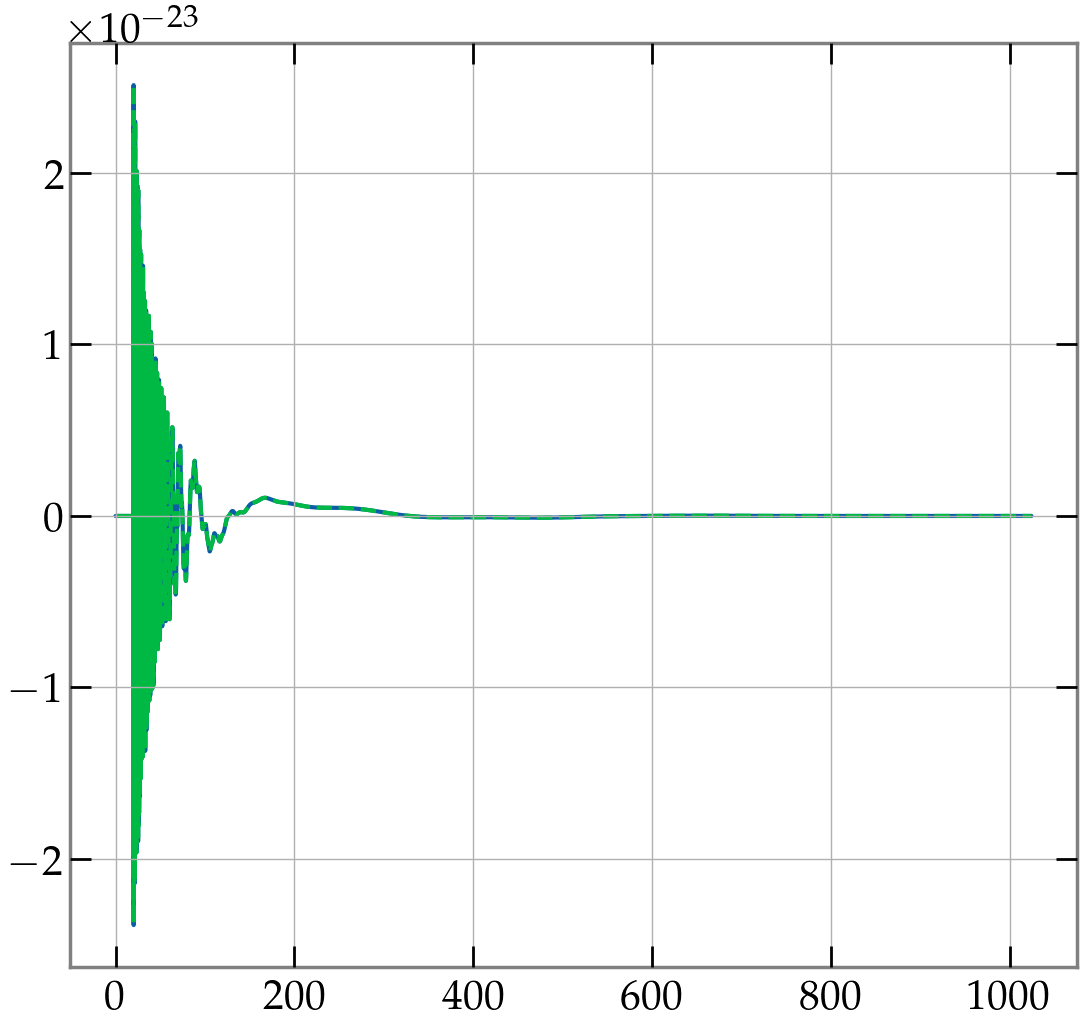

In [49]:
plt.plot(hp_f)
plt.plot(hp_f_v2, '--')

    
plt.show()

### Time Domain

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

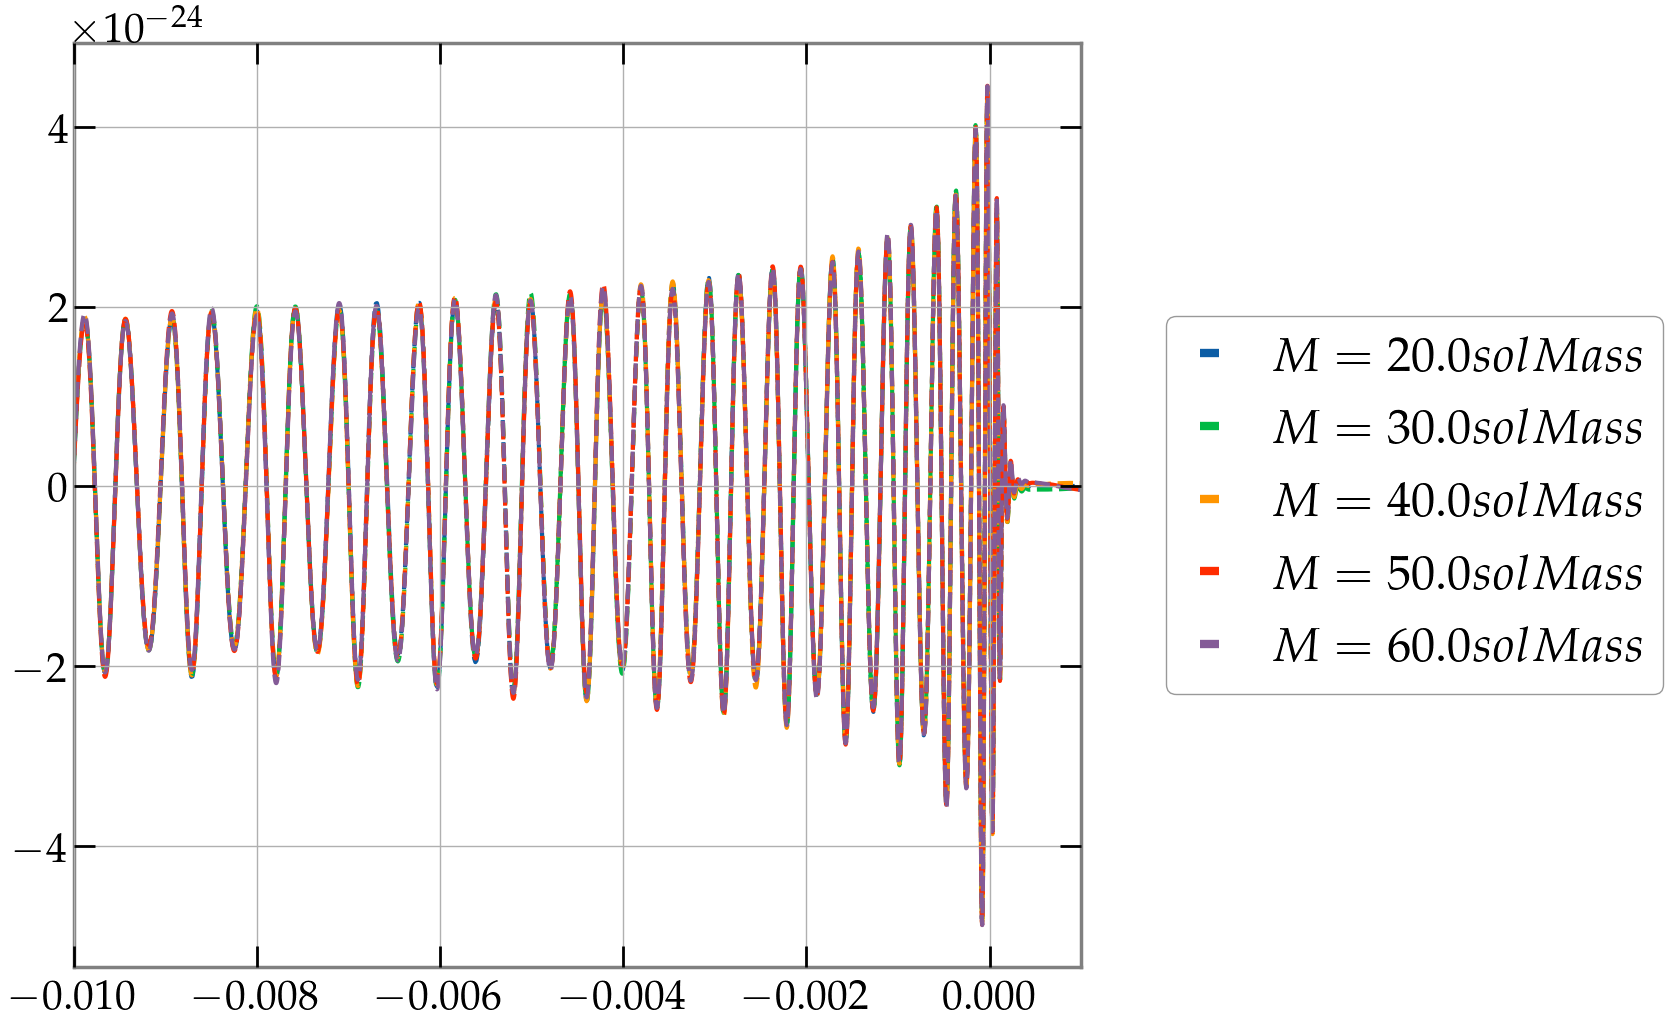

In [50]:
for M in u.Quantity([20.0, 30.0, 40.0, 50.0, 60.0], u.solMass):  # Testing only small masses
# for M in u.Quantity([100.0, 150.0, 200.0, 250.0], u.solMass):  # Testing only large masses
    M_in_s = M * Msun_to_kg * kg_to_s

    hp_t, _ = wfm.GenerateTDWaveform(
        wf_center_parameters | {
            'total_mass': M,
            'f22_start': 10.*u.Hz,  # Adjust so that we have good frequency range after multiplication
            # 'f22_start': f_min / M.value,  # Adjust so that we have good frequency range after multiplication
            # 'f_max' : f_max / M.value,  # Adjust so that we have good frequency range after multiplication
            'f22_ref': f_ref / M.value,  # Does not play a role -> IT DOES
            'deltaT' : 1./4096. * u.s
        },
        gen
    )


    # Rescaling to/in geometric units
    # hp_t /= M_in_s
    # hp_t.times /= M_in_s
    

    # Rescaling in cosmological units
    hp_t /= M
    hp_t.times /= M
    
    
    plt.plot(hp_t, '--', label=f'$M = {M}$')

plt.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')


# For scaled times (cosmological units)
# plt.xlim([-1., 0.001])
plt.xlim([-0.01, 0.001])
# plt.xlim([-0.001, 0.001])

# For scaled times (geometric units)
# plt.xlim([-0.01e5, 0.001e5])
# plt.xlim([-0.001e5, 0.001e5])
    
plt.show()

In [51]:
mass1 = M_center
mass2 = 0.5 * M_center
mass3 = 0.25 * M_center


# deltaT = 1./1024.*u.s
# deltaT = 1./2048.*u.s
deltaT = 1./4096.*u.s

# unit_sys = 'cosmo'
unit_sys = 'geom'

wf_center_parameters['condition'] = 1

# hp_t_M1 = get_mass_scaled_wf(wf_center_parameters | {'total_mass': mass1, 'deltaT': deltaT * mass1.value}, 'TD', gen, unit_sys)
# hp_t_M2 = get_mass_scaled_wf(wf_center_parameters | {'total_mass': mass2, 'deltaT': deltaT * mass2.value}, 'TD', gen, unit_sys)
# hp_t_M3 = get_mass_scaled_wf(wf_center_parameters | {'total_mass': mass3, 'deltaT': deltaT * mass3.value}, 'TD', gen, unit_sys)
hp_t_M1 = get_mass_scaled_wf(wf_center_parameters | {'total_mass': mass1, 'deltaT': deltaT}, 'TD', gen, unit_sys)
hp_t_M2 = get_mass_scaled_wf(wf_center_parameters | {'total_mass': mass2, 'deltaT': deltaT}, 'TD', gen, unit_sys)
hp_t_M3 = get_mass_scaled_wf(wf_center_parameters | {'total_mass': mass3, 'deltaT': deltaT}, 'TD', gen, unit_sys)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

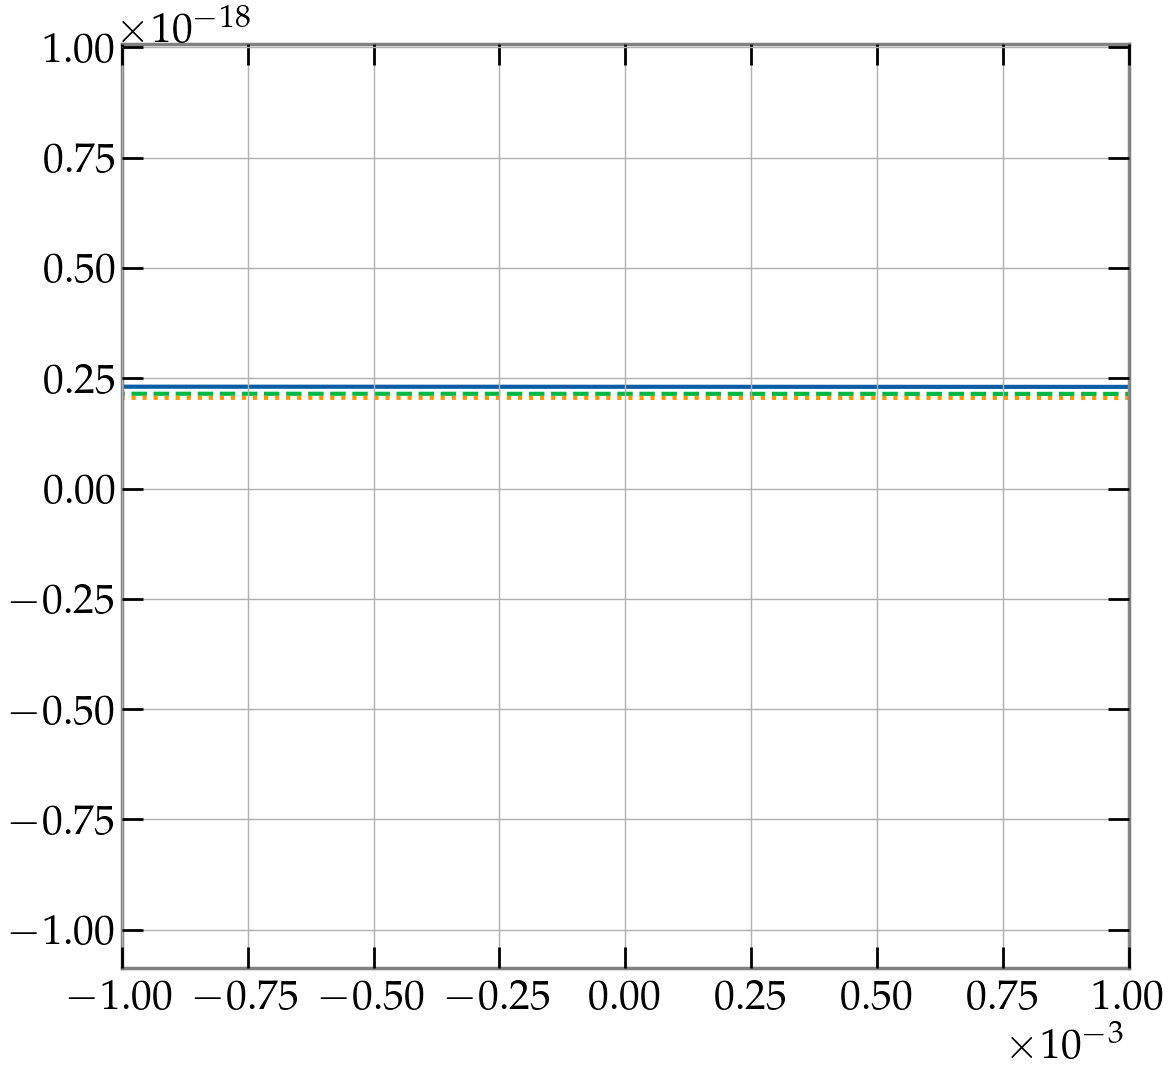

In [52]:
plt.plot(hp_t_M1)
plt.plot(hp_t_M2, '--')
plt.plot(hp_t_M3, ':')

# plt.xlim([-0.01, 0.002])
plt.xlim([-0.001, 0.001])
# plt.xlim([-0.01 / const.M_sun.value, 0.001 / const.M_sun.value])
# plt.xlim([-0.01 / (Msun_to_kg * kg_to_s).value, 0.001 / (Msun_to_kg * kg_to_s).value])

plt.show()

Let's see how the Fourier transforms of this look like and in particular, if it coincides with the rescaled frequency domain waveform

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

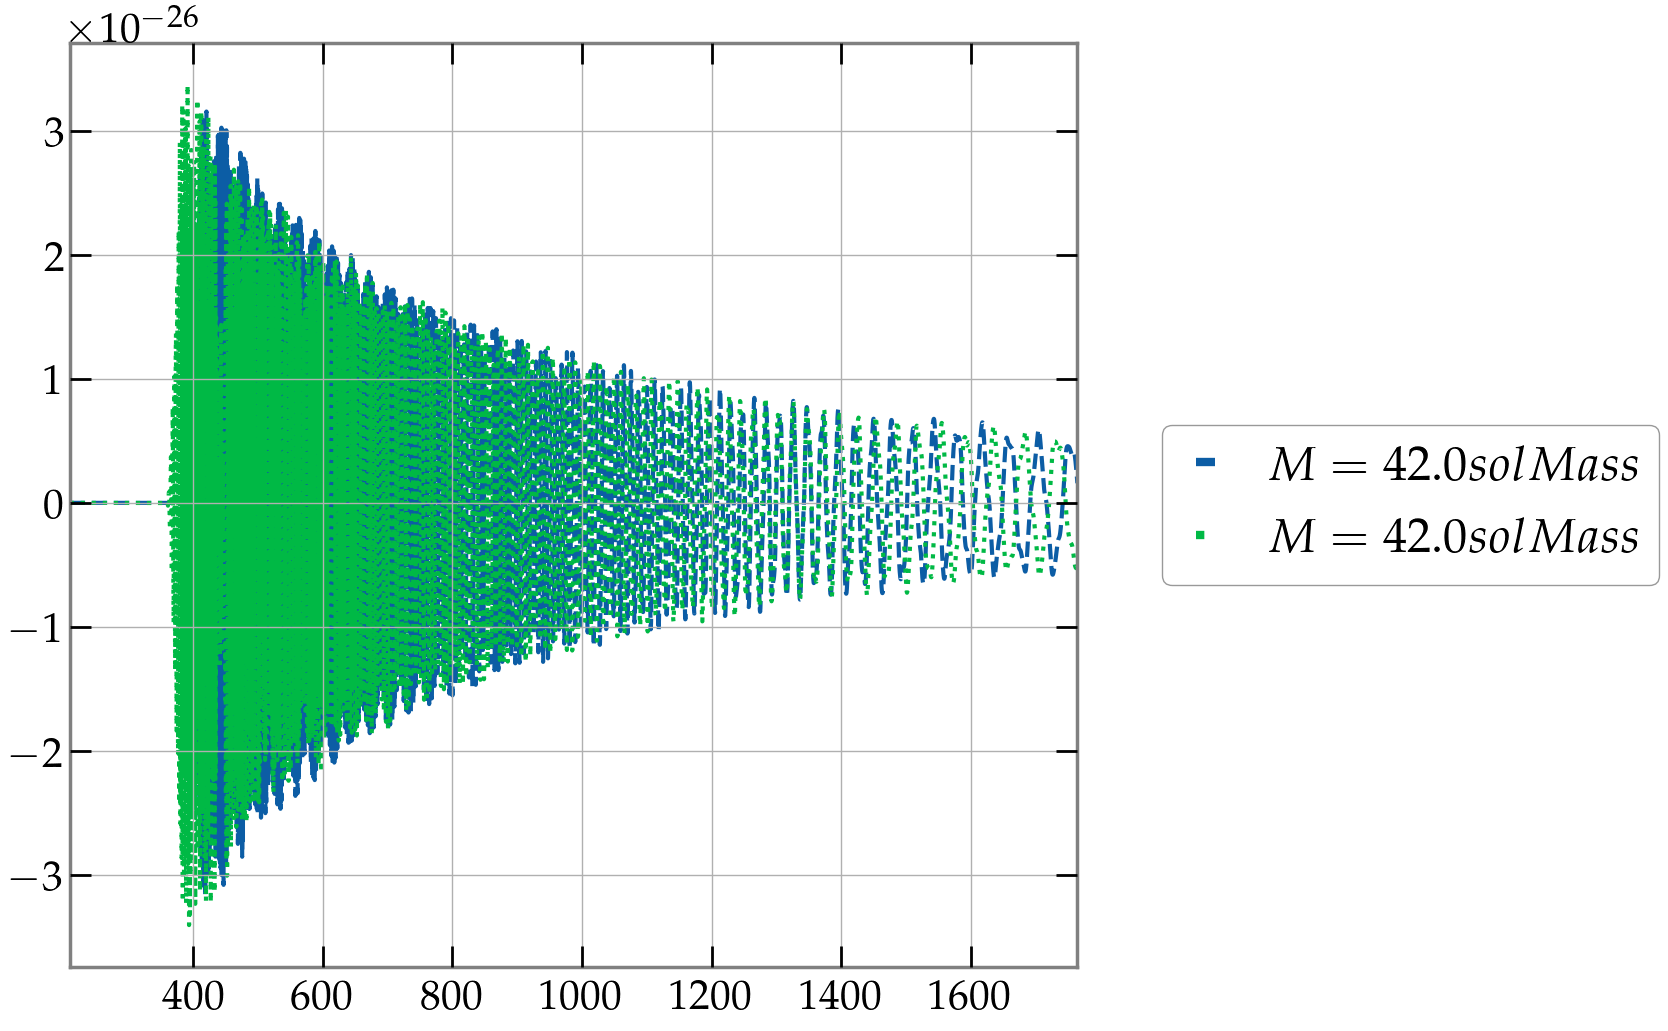

In [53]:
M = M_center
f_min_smaller = 10.*u.Hz
f_max_smaller = 1000.*u.Hz


hp_f, _ = wfm.GenerateFDWaveform(
    wf_center_parameters | {
        'total_mass': M,
        # 'f22_start': f_min / M.value,  # Makes kernel crash, thus we choose fixed limit
        # 'f_max' : f_max / M.value,  # Makes kernel crash, thus we choose fixed limit
        'f22_start': f_min_smaller,
        'f_max': f_max_smaller,
        'deltaF' : 2**-8*u.Hz,
        'f22_ref': f_ref / M.value,  # Does not play a role -> IT DOES
    },
    gen
)

hp_f /= M**2
hp_f.frequencies *= M
    
plt.plot(hp_f, '--', label=f'$M = {M}$')


hp_t, _ = wfm.GenerateTDWaveform(
    wf_center_parameters | {
        'total_mass': M,
        # 'f22_start': f_min / M.value,  # Makes kernel crash, thus we choose fixed limit
        # 'f_max' : f_max / M.value,  # Makes kernel crash, thus we choose fixed limit
        'f22_start': f_min_smaller,
        'f_max': f_max_smaller,
        'f22_ref': f_ref / M.value,  # Does not play a role -> IT DOES
        'deltaT' : 1./4096. * u.s,

        # 'f22_start': f_min / M_in_s.value,  # Adjust so that we have good frequency range after multiplication
        # 'f_max' : f_max / M_in_s.value,  # Adjust so that we have good frequency range after multiplication
        # 'deltaF' : 2**-8*u.Hz,
        # 'f22_ref': f_ref / M_in_s.value,  # Does not play a role
    },
    gen
)
    
hp_t /= M.value
hp_t.times /= M.value


hp_f_2 = td_to_fd_waveform(hp_t)

plt.plot(hp_f_2, ':', label=f'$M = {M}$')



plt.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

plt.xlim([5 * M.value, 42 * M.value])
# plt.xlim([10 * M.value, 24 * M.value])  # Zoom in
# plt.ylim([-1.5e-26, 1.5e-26])


plt.show()

Looks good, so calculations using this one should be equivalent. Since length of templates increases with $M$, the sample size also increases, which means that $df$ decreases for constant $dt$ (this is what we observe here).